# **Projeto de Pipeline de Dados no Telegram**

## 1. Contextualização

Atualmente, a maioria das empresas possui um sistema de atendimento ao consumidor chamados de *chatbot*. O usuário manda mensagem para tirar alguma dúvida ou resolver alguma situação e ao invés de ter uma pessoa pronta para atende-lo, ela irá conversar com um robo já programado pela própria empresa que é capaz de solucionar as dúvidas mais frequentes que os clientes tem. Se o robo não conseguir solucionar a situação então é passado para um atendente real.

A ideia deste projeto é oferecer uma solução para poder analisar as mensagens recebidas por um *chatbot* para tirar conclusões que possam ajudar o negócio, por exemplo:
* Qual a dúvida ou situação mais frequente?
* Qual horário mais acessado pelos usuários?
* Existe alguma forma de aprimorar o bot para diminuir os atendimentos reais?
* E outras que possam surgir...

Vou deixar o link do repositório do Github e do meu Linkedin para quem tiver interesse

* [Github](https://github.com/gabrielwsb/projeto_final_dados)
* [Linkedin](https://www.linkedin.com/in/gabriel-william-353b9361/)

## 2. Arquitetura

O procedimento será realizado da seguinte forma:

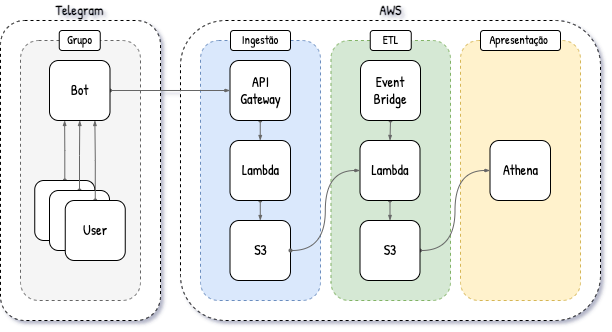

* **Telegram**

O Telegram é a fonte dos dados. Quando um usuário envia uma mensagem em um grupo, um bot captura essa mensagem e a envia para um endereço na internet, por meio do webhook do aplicativo. Esse endereço é fornecido pelo AWS API Gateway e aceita esse tipo de envio. A mensagem vai dentro do corpo da requisição.

* **AWS - Ingestão**

O conteúdo da mensagem chega por uma requisição HTTP e é recebido pelo AWS API Gateway, que envia essa informação para o AWS Lambda. O Lambda usa essa informação (chamada de event), salva o conteúdo em um arquivo JSON e armazena no AWS S3, organizado por dia.

* **AWS - ETL**

Uma vez por dia, o AWS EventBridge ativa o AWS Lambda, que processa as mensagens do dia anterior. Ele organiza os dados do formato JSON, transforma em um formato mais leve chamado Apache Parquet e salva tudo no AWS S3, separado por dia.



> **Simplificando...**



1. As mensagens virão de um grupo no Telegram;
2. Todas as mensagens serão salvas em um bucket do AWS S3 em formato .csv
3. As mensagens de um dia serão salvas em um único arquivo .parquet. Esta opção é pensando em consultas SQL no AWS Athena.

## 3. Preparação inicial

Antes de começarmos, eu gosto de importar todos os módulos e pacotes que irei utilizar no projeto.

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.5 MB/s eta 0:00:00


In [ ]:
import json
import os
import logging
from getpass import getpass
from datetime import datetime, timedelta, timezone

import boto3
import requests
import pyarrow as pa
import pyarrow.parquet as pq



## 4. Telegram

O que será feito no Telegram:
1. Criar um bot no Telegram
2. Crio um grupo, adiciono o bot e outras pessoas
3. Coloco o bot como administrador do grupo
4. Desligo a opção de outras pessoas adicionarem este bot a um grupo


* Bot criado

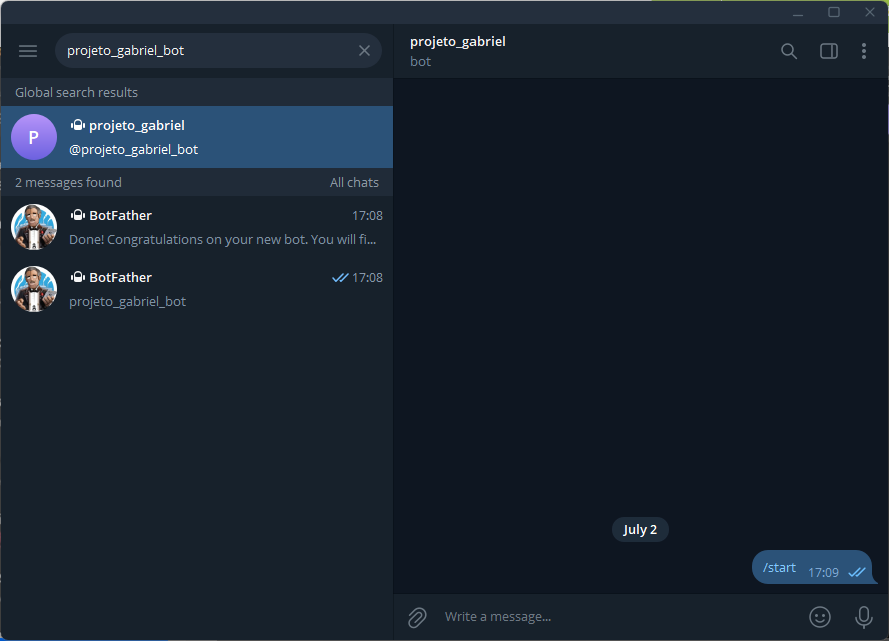

* Grupo criado

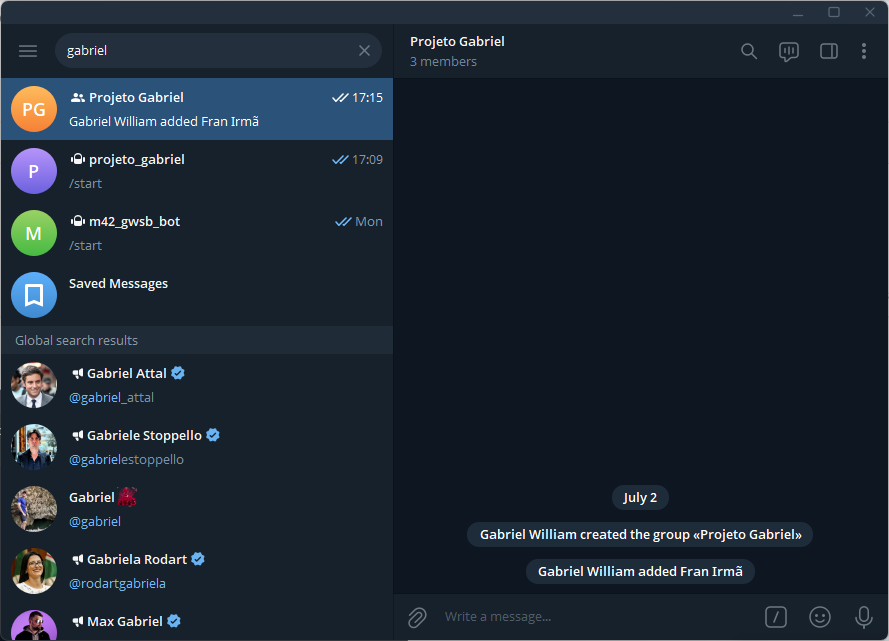

### 4.1 API para o bot capturar as mensagens

Uma mensagem capturada via API é um dado semiestruturado JSON com algumas chaves padronizadas e outras opcionais, a depender do tipo da mensagem. Por exemplo, mensagens de texto apresentam a chave `text` enquanto mensagens de áudio apresentam a chave `audio`.

Vou colocar o token da API numa variavel e atribui-lo a url base comum dos métodos API

In [ ]:
token = getpass()

··········


In [ ]:
base_url = f'https://api.telegram.org/bot{token}'

Vamos verificar se a integração ocorreu com sucesso. O método getMe para retornar informações do bot e o getUpdates das mensagens enviadas. Para este primeiro teste eu enviei algumas mensagens de texto, audio e imagem.

In [ ]:
# Verificando as informações do bot
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

https://api.telegram.org/bot7972287206:AAFZtjOY-vBucPfZ8SUCxlT5qUAik421Mr0/getMe
{
  "ok": true,
  "result": {
    "id": 7972287206,
    "is_bot": true,
    "first_name": "projeto_gabriel",
    "username": "projeto_gabriel_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


A linha `"is_bot": true` confirma que o bot está configurado corretamente.


In [ ]:
# Verificando se está captando mensagens
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 159820908,
      "message": {
        "message_id": 6,
        "from": {
          "id": 687237155,
          "is_bot": false,
          "first_name": "Gabriel",
          "last_name": "William",
          "language_code": "pt-br"
        },
        "chat": {
          "id": 687237155,
          "first_name": "Gabriel",
          "last_name": "William",
          "type": "private"
        },
        "date": 1751564966,
        "text": "teste"
      }
    },
    {
      "update_id": 159820909,
      "message": {
        "message_id": 9,
        "from": {
          "id": 687237155,
          "is_bot": false,
          "first_name": "Gabriel",
          "last_name": "William",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002708887364,
          "title": "Projeto Gabriel",
          "type": "supergroup"
        },
        "date": 1751564990,
        "text": "teste"
      }
    }
  ]
}


* **Mensagens de texto**

As mensagens de texto são capturadas com o identificador: `"text": "Ol\u00e1 mundo"`

* **Mensagens de Áudio**

As mensagens de aúdio são capturadas com o identificador:
`"voice": {
          "duration": 10,
          "mime_type": "audio/ogg",`

* **Fotos**

As fotos são capturadas com o identificador: `"photo":` seguido de informações do dimensionamento da imagem.



> Neste projeto irei focar apenas em mensagens do tipo **texto**.



## 5. Ingestão

Esta é a etapa responsável pela ingestão dos dados transacionais para a plataforma que iremos utilizar, neste caso o Amazon AWS. Importante ressaltar que eu quero pegar o dado no seu formato mais original possível, sem fazer nenhum tipo de transformação lógica ou de formato.

Para realizar a ingestão dos dados, vamos utilizar um *webhook* para redirecionar as mensagens para outra API da Web. Nesta etapa utilizaremos o *AWS API Gateway*.

Desta forma, a execução será da seguinte maneira:
1. As mensagens serão capturadas via webhook
2. Serão redirecionadas para AWS API Gateway
3. Após, serão redirecionadas para AWS Lambda que irá armazenar o dado em seu formato original .JSON.
4. Após isso serão armazenadas em um Bucket do S3.

* **O que precisamos fazer agora:**

1. Criar um Bucket no S3
2. Definir as variaveis de ambiente
3. Definir as permissões
2. Configurar a função no AWS Lambda
3. Criar um API no AWS API Gateway
4. Configurar o webhook da API de bots do Telegram.

### 5.1 AWS S3

O Bucket será responsável pelo armazenamento dos arquivos originais.

* Bucket criado

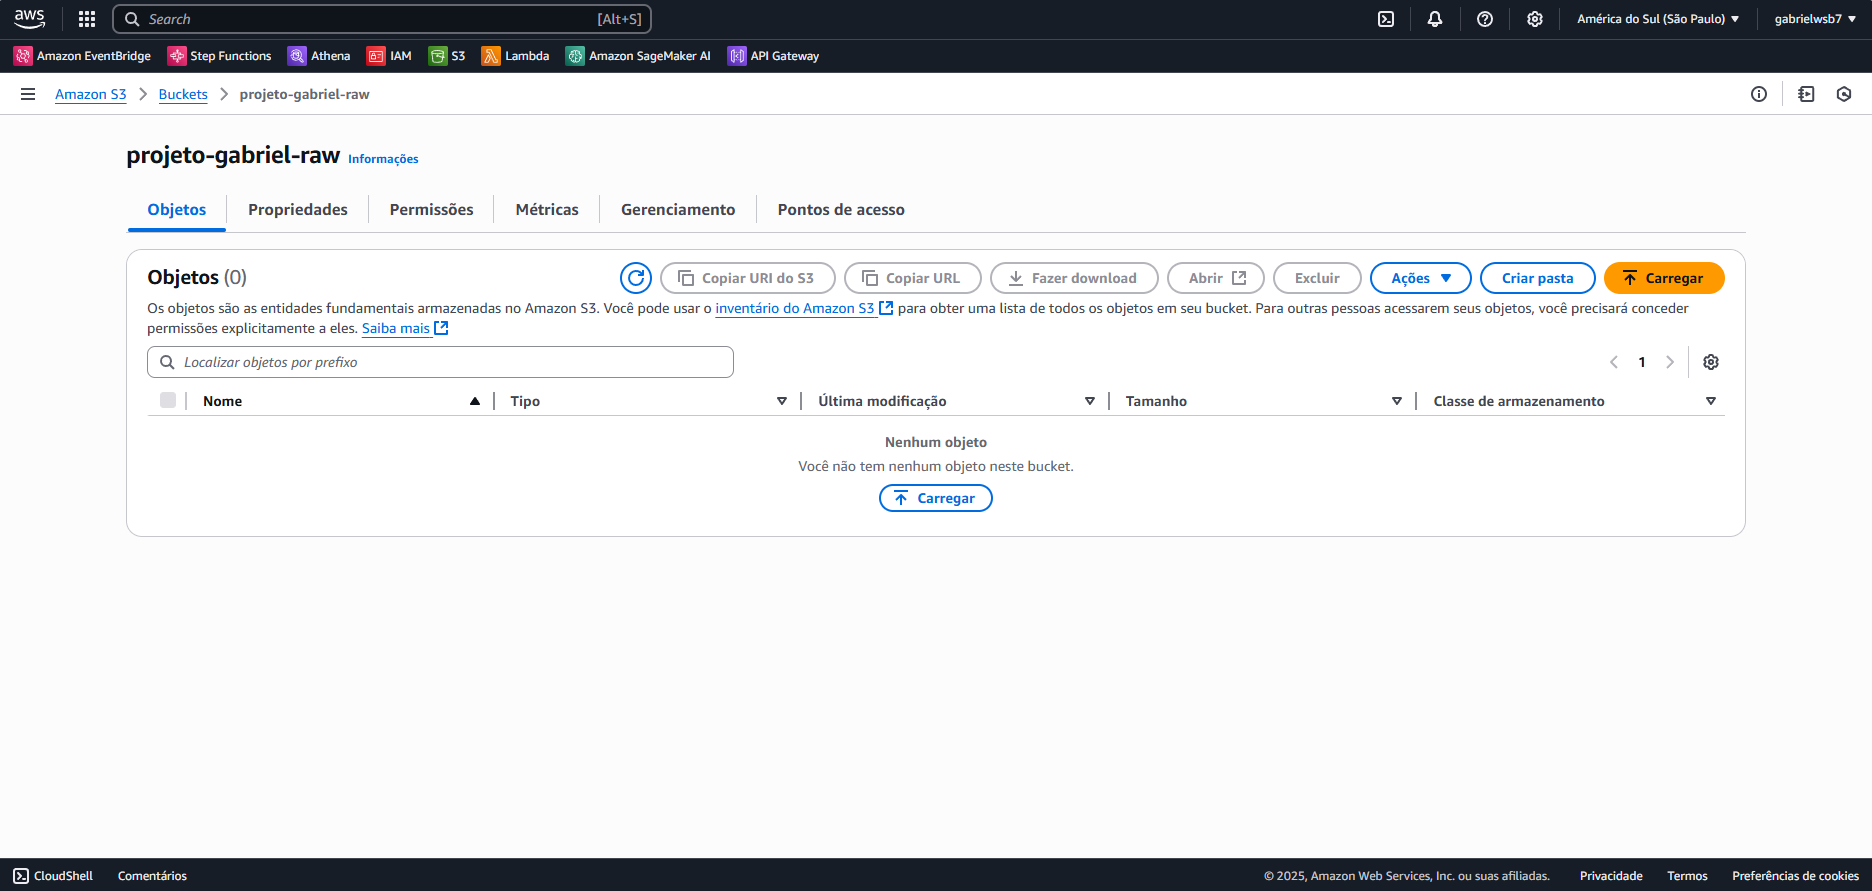

### 5.2 AWS Lambda

Aqui iremos configurar as funções para o processamento das mensagens e os redirecionamentos. O código precisa realizar as seguintes tarefas:

* Recebe a mensagem no parâmetro `event`;
* Verifica se a mensagem tem origem no grupo do Telegram correto;
* Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
* Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do Telegram.

* Criando as variáveis ambiente

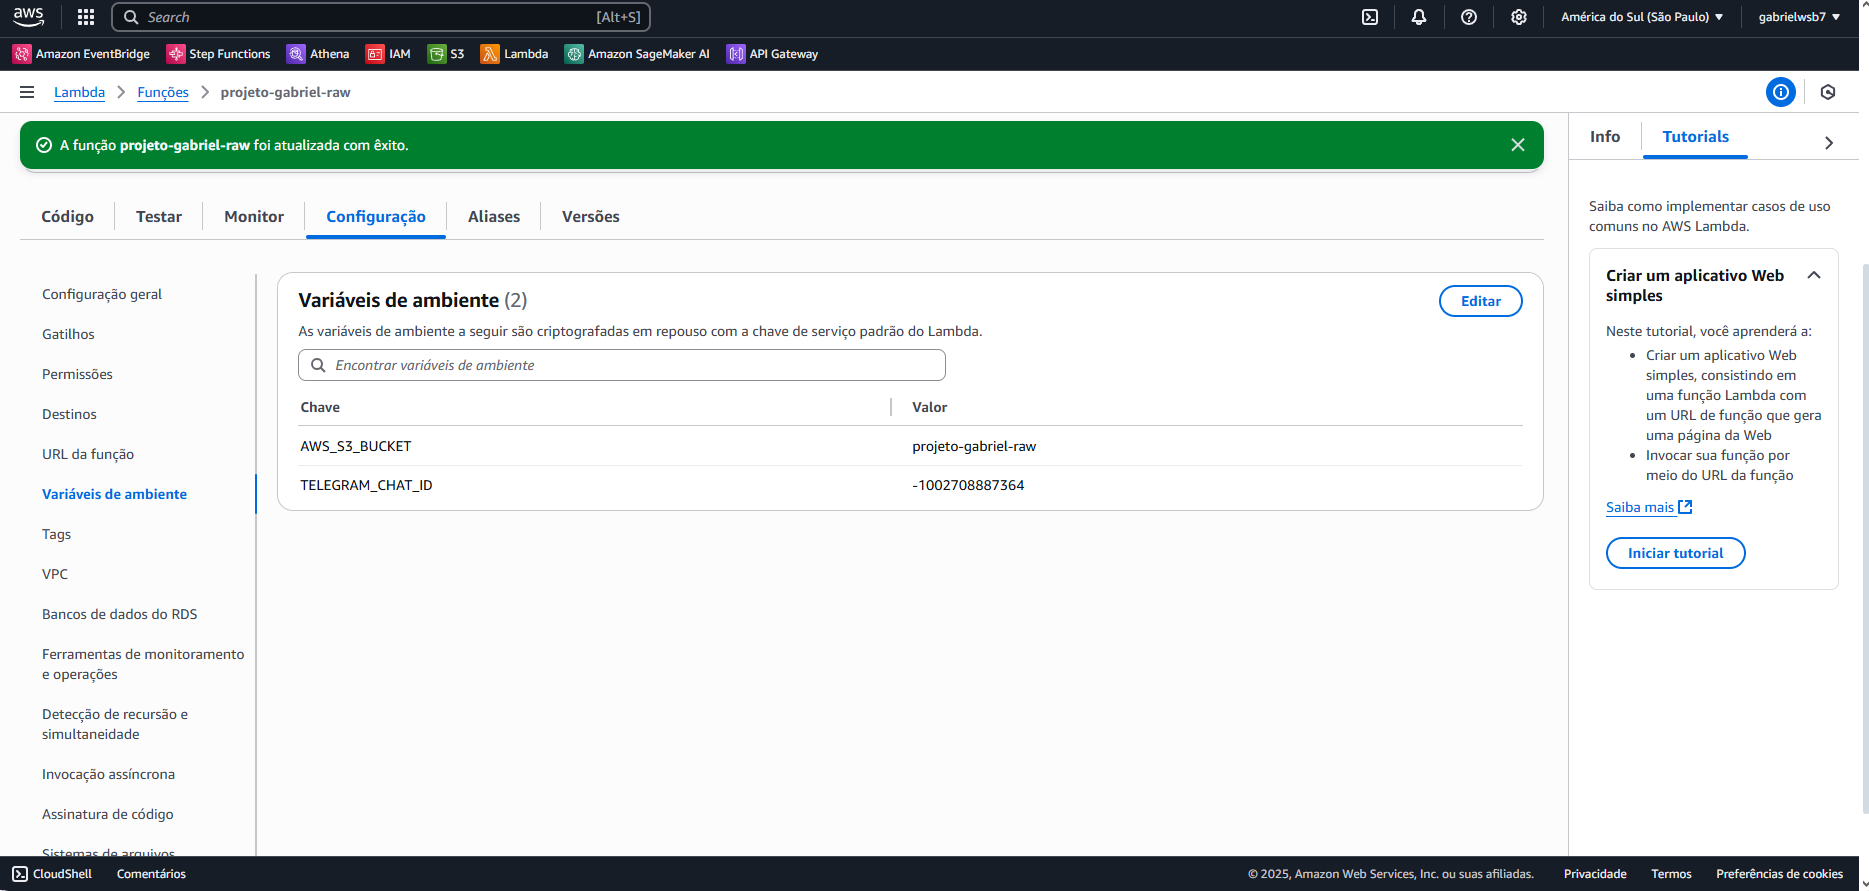

* Definindo as permissões

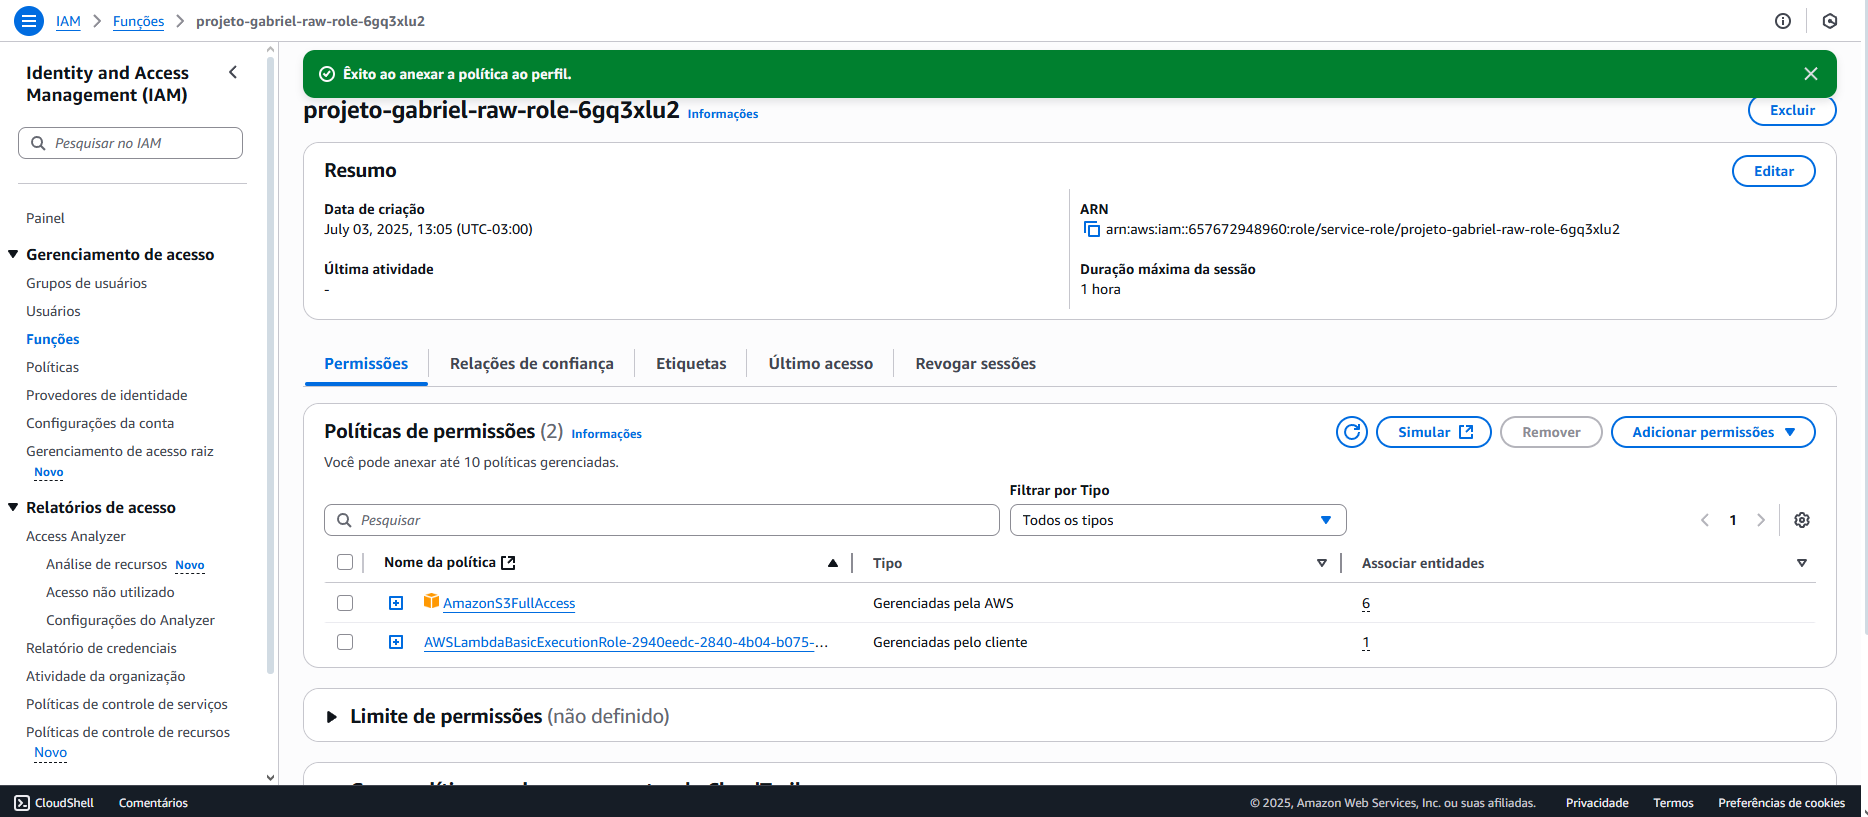

* Criando a função

In [ ]:
def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # Variáveis de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # Variáveis lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

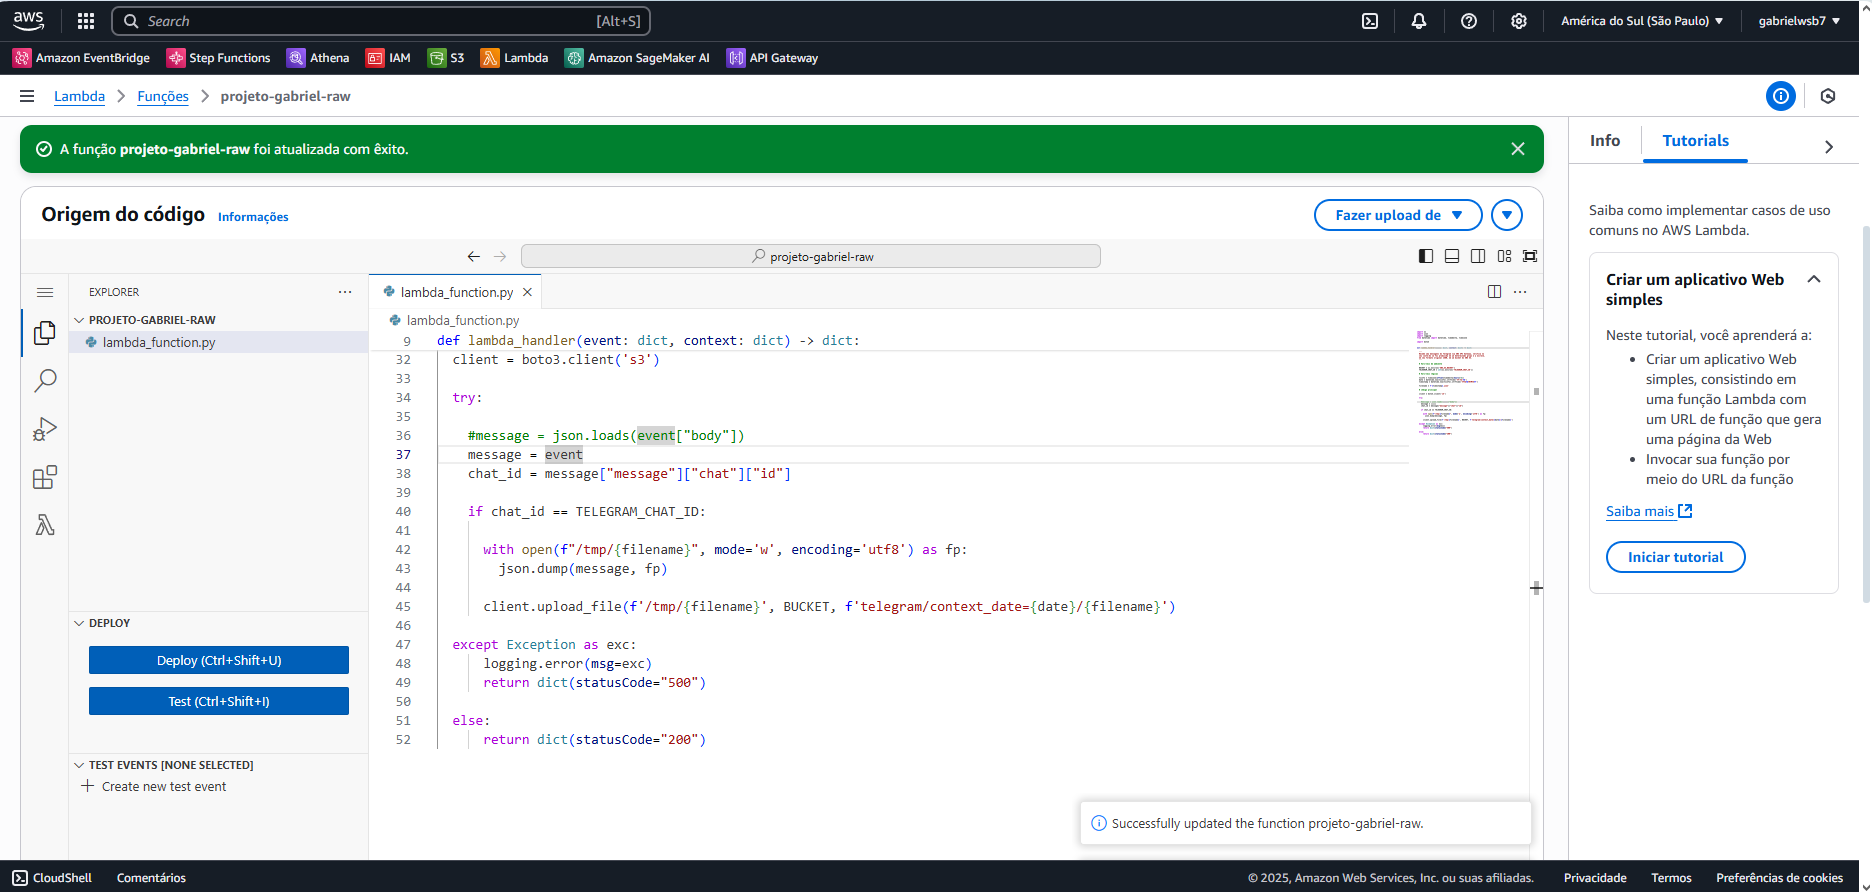

Nesta etapa irei realizar um teste para verificar se está funcionando como deveria. Para testar, copiei o trecho de uma mensagem capturada nos códigos acima.

* Evento teste com sucesso

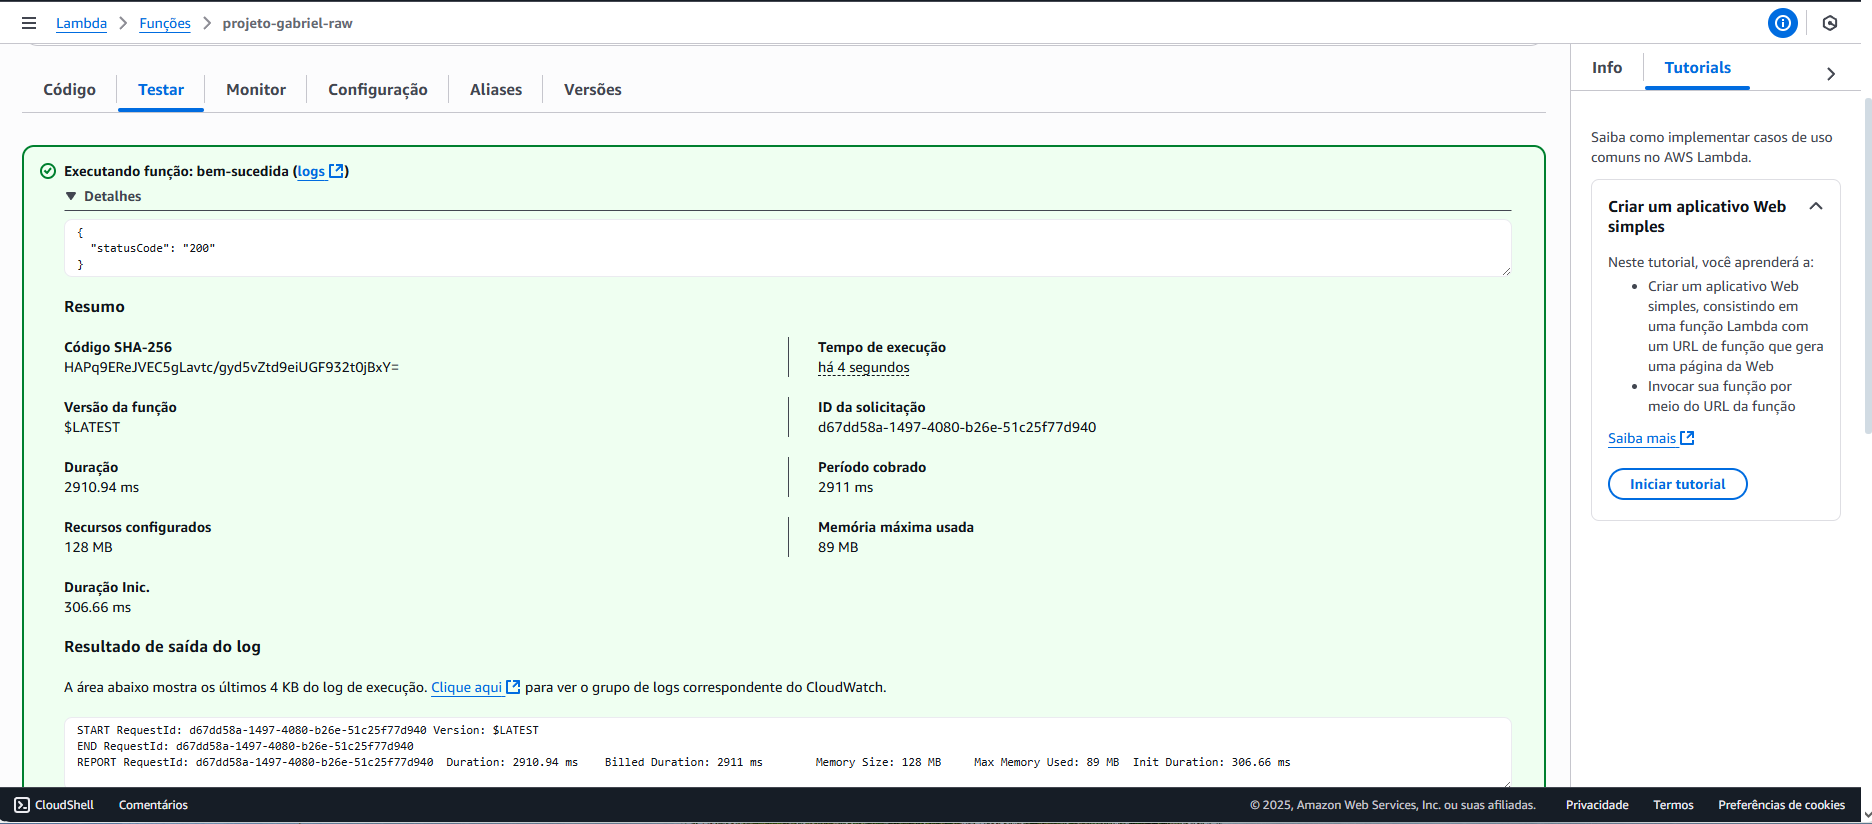

* Arquivo apareceu no Bucket

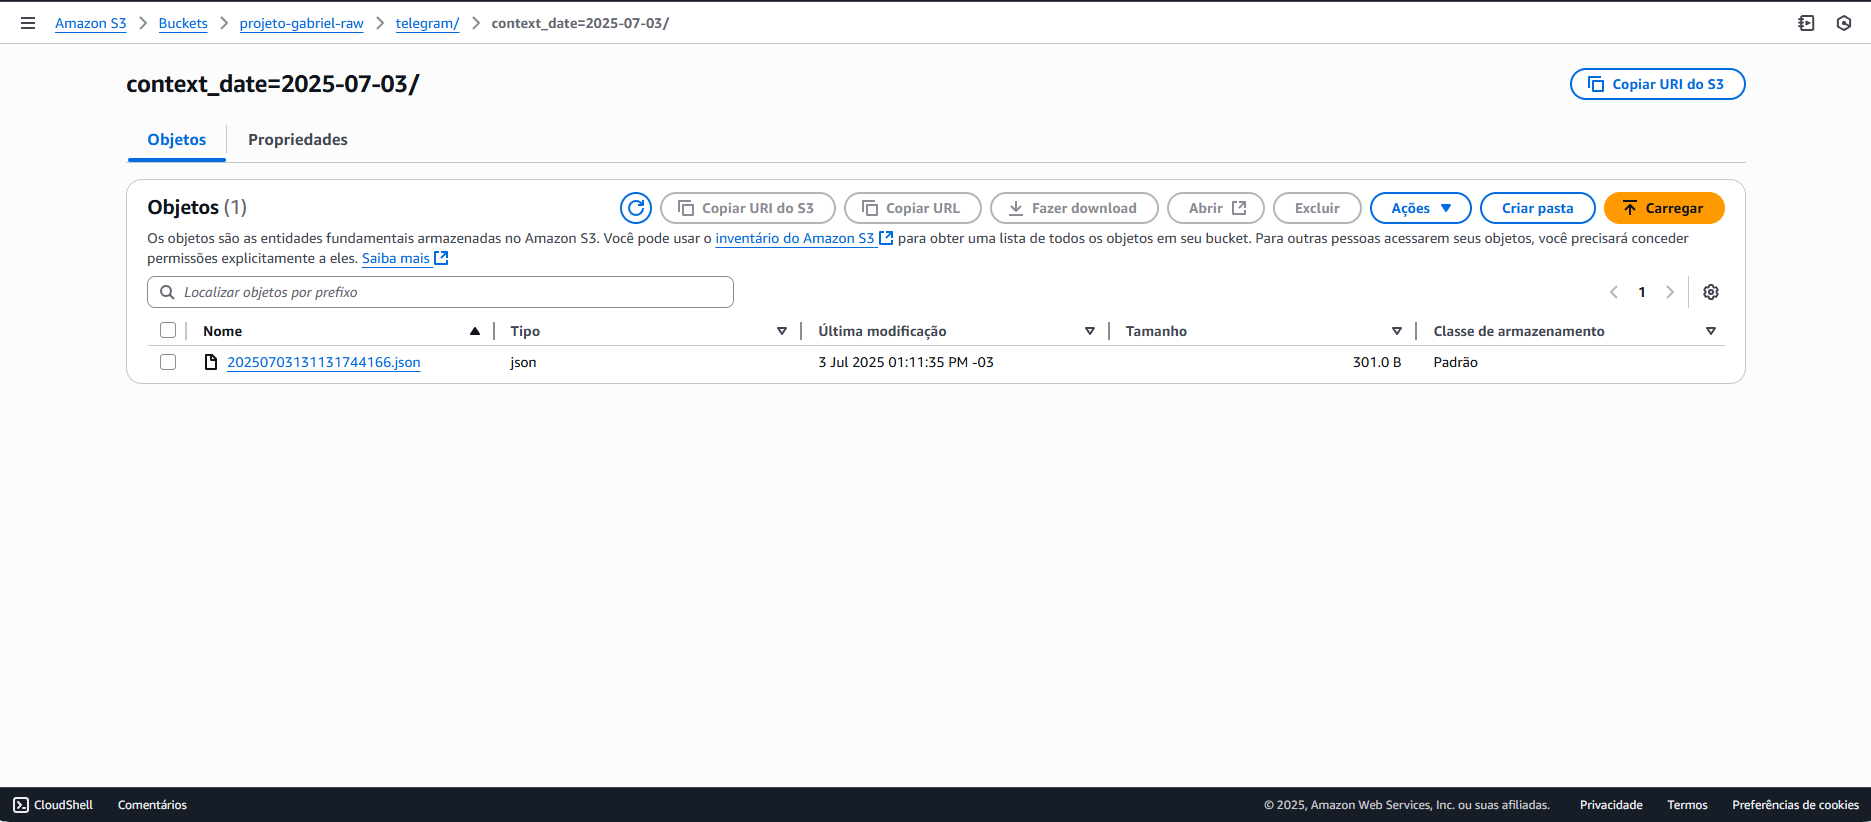

### 5.3 AWS API Gateway

Agora irei criar uma API do tipo REST para fazer a ponte entre o *webhook* e o Lambda

* API criada

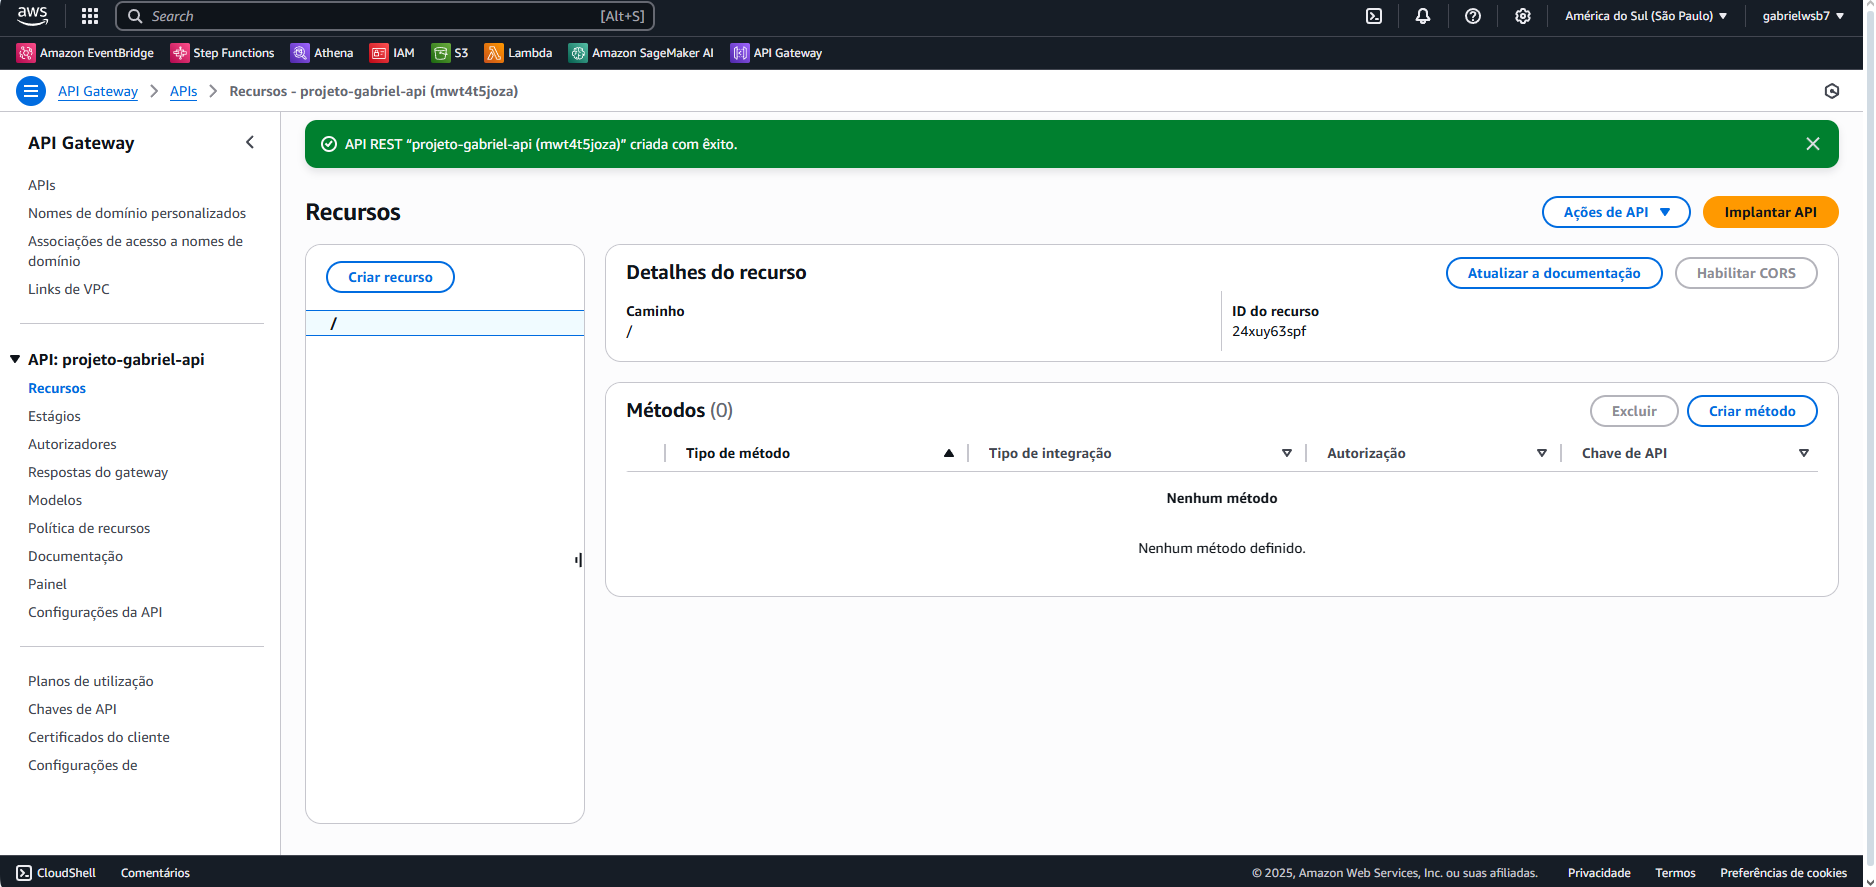

* Método para API criado

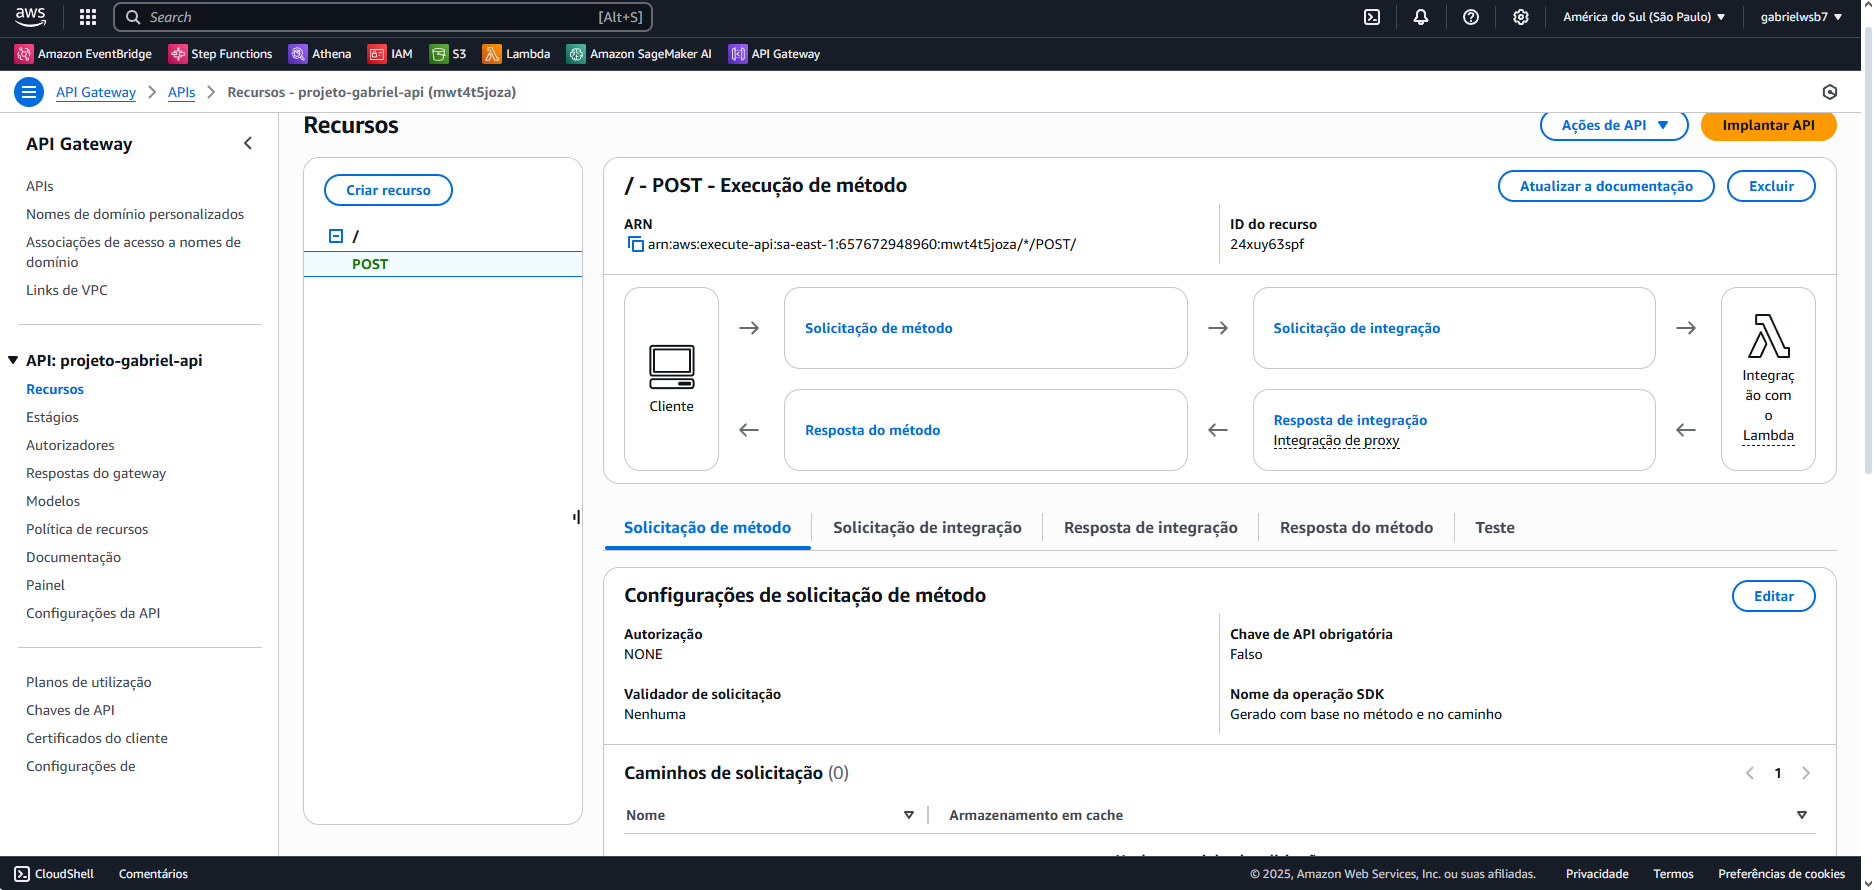

* Teste para verificar se a API está funcionando corretamente

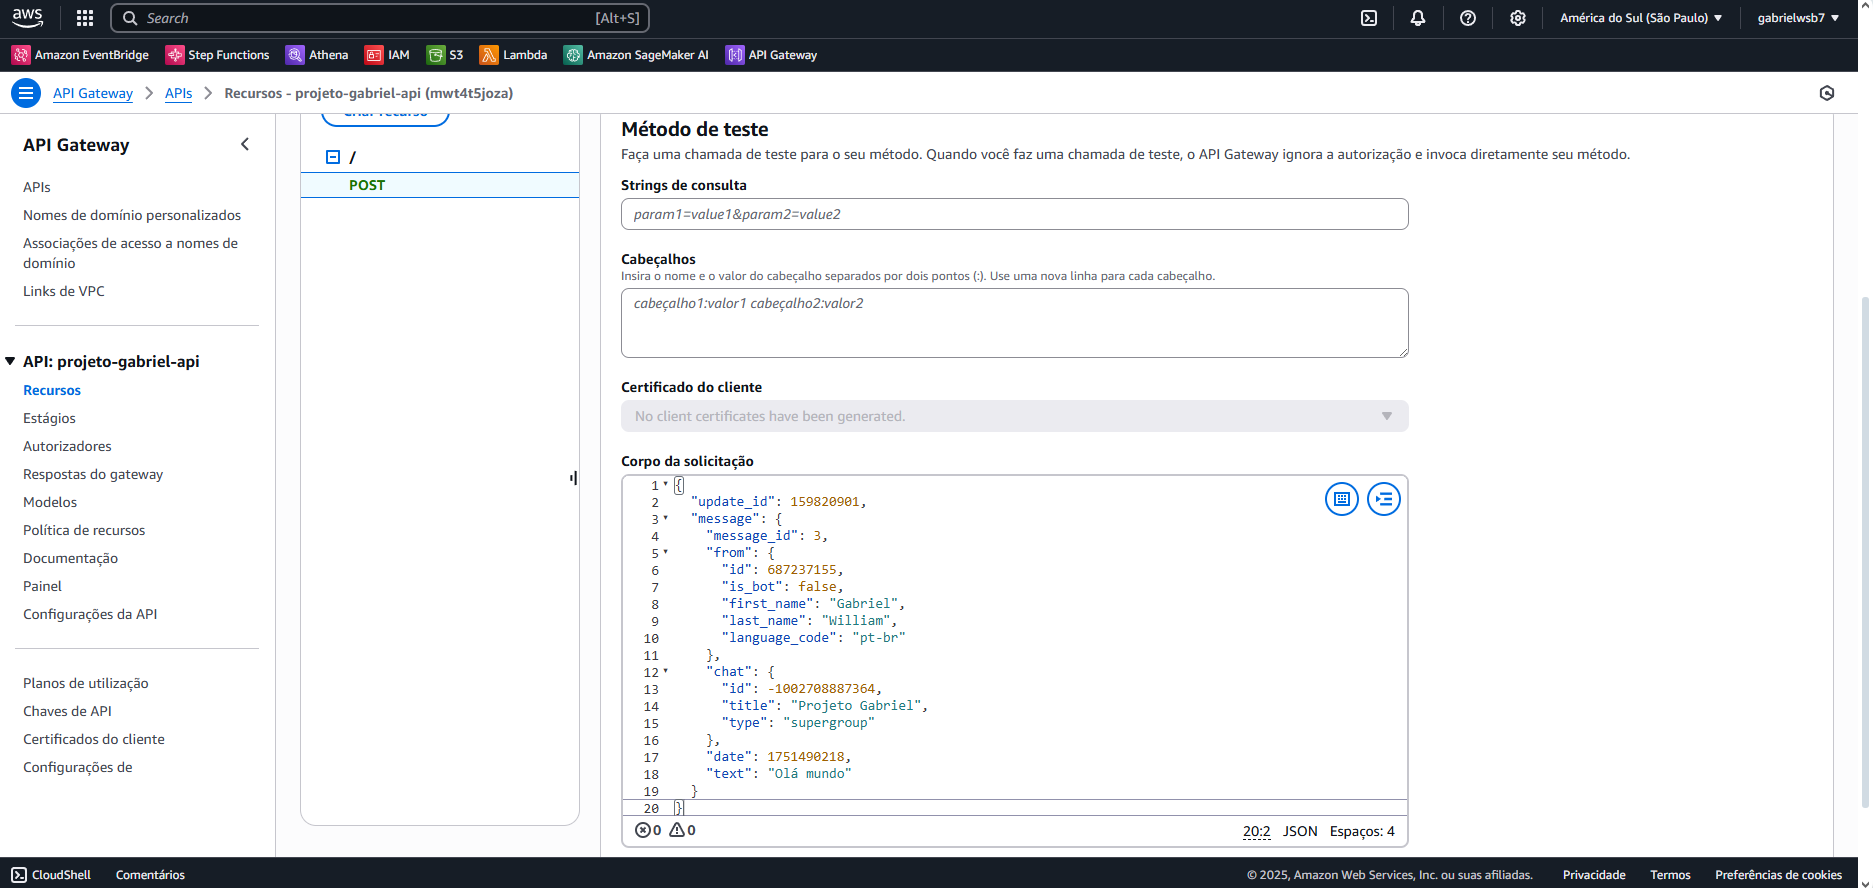

* Teste realizado com sucesso

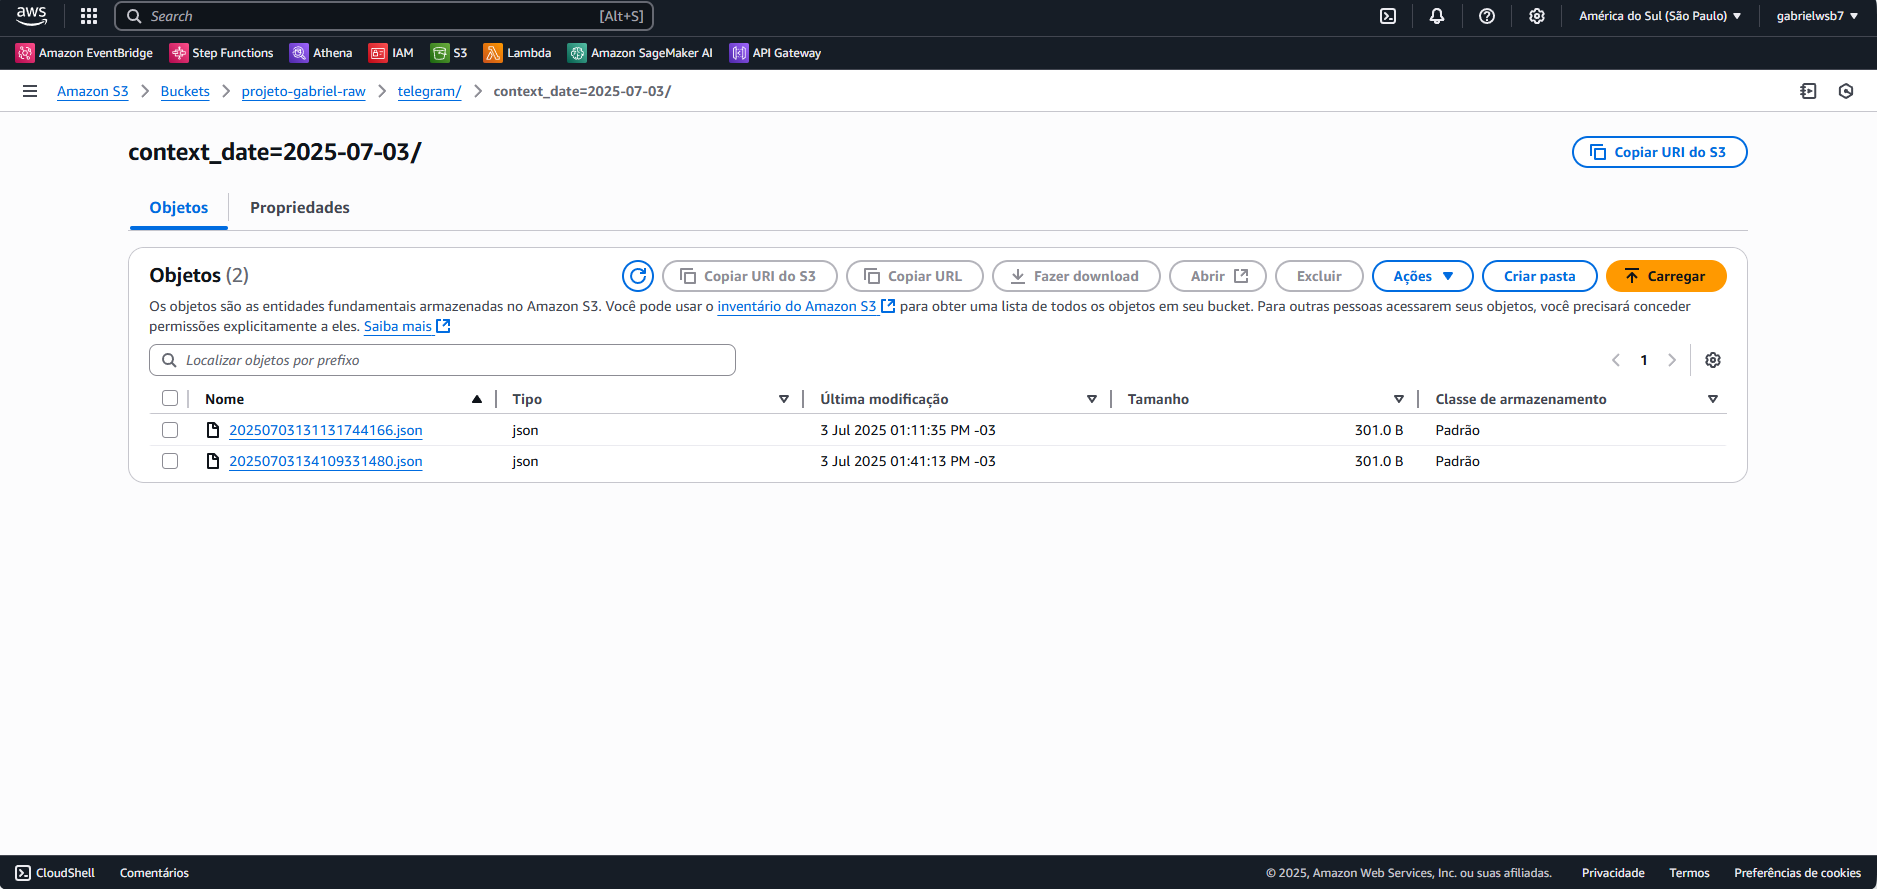

* Final: implantar a API

COLAB BUGOU E NAO DEIXA EU ADICIONAR A IMAGEM

Com a API implantada agora vamos atribuir a url dela para uma variavel

In [ ]:
aws_api_gateway_url = getpass()

··········


### 5.4 Webhook no Telegram

Vamos configurar o *webhook* para redirecionar as mensagens para a url do AWS API Gateway.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


Vamos confirmar se o webhook está devidamente configurado


In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://2719a0blx3.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 2,
    "max_connections": 40,
    "ip_address": "54.232.201.100"
  }
}


* Agora vou testar enviado a mensagem "projeto gabriel"

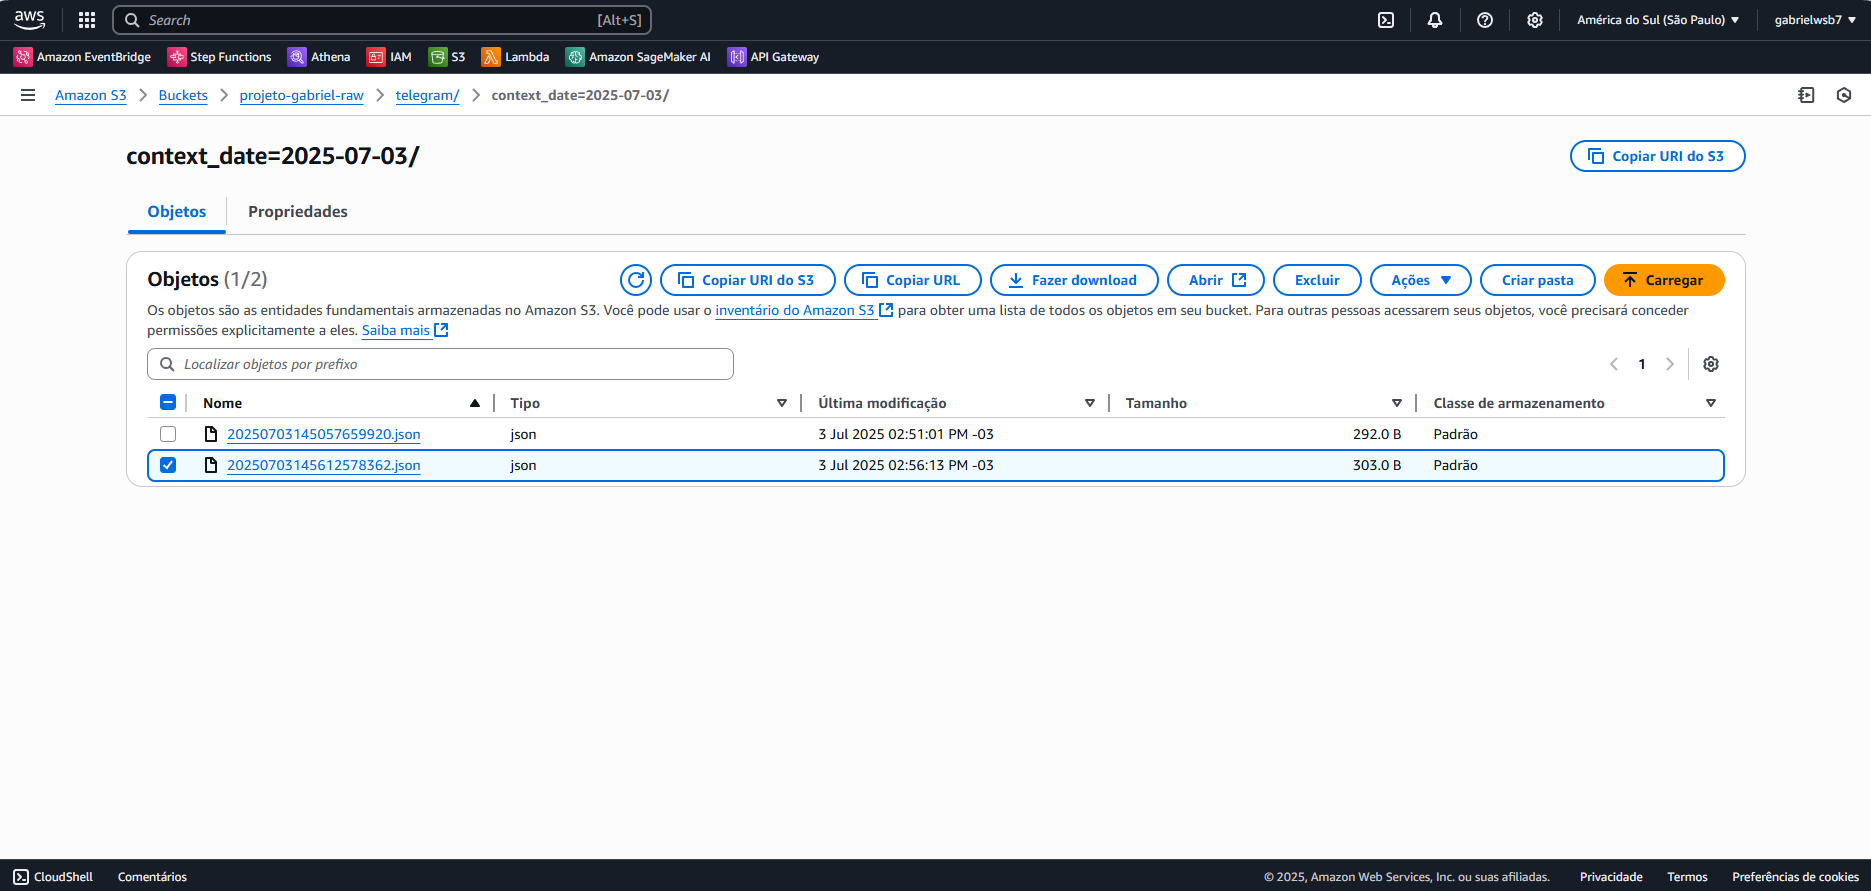

* Print do arquivo gerado

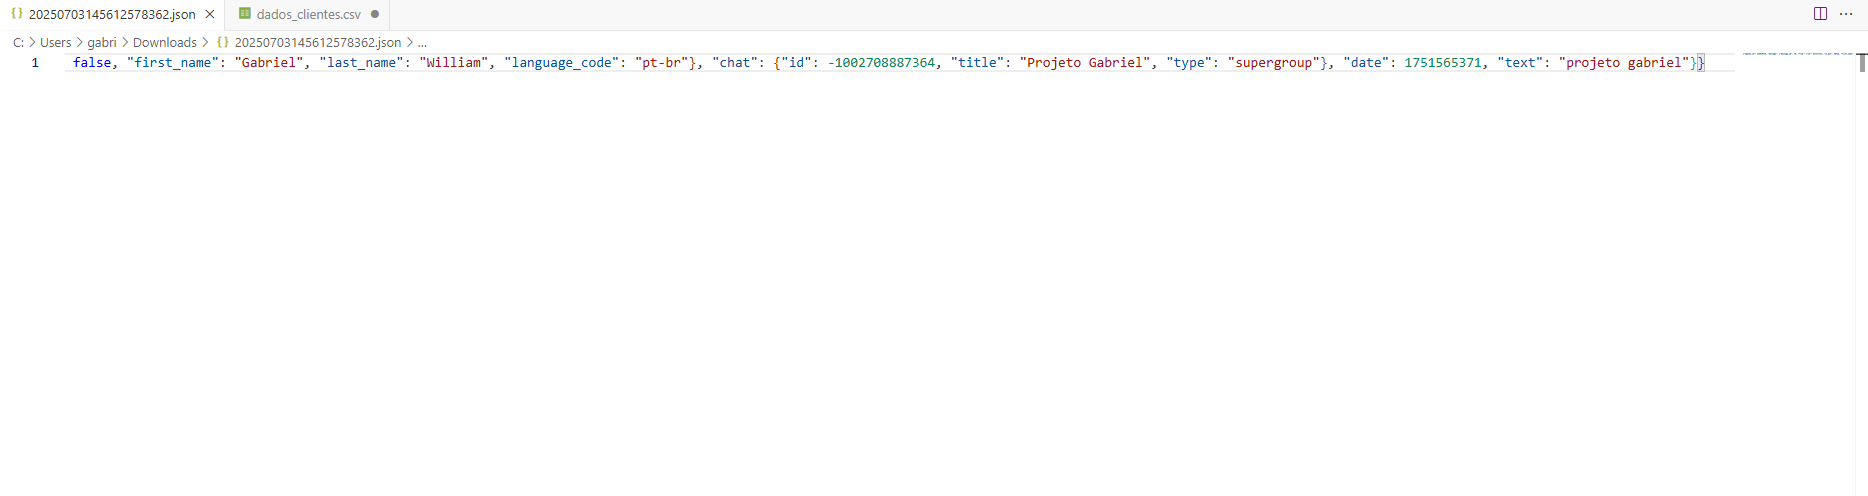

## 6. Uma segunda camada: ETL

Nesta etapa, irei realizar o que é chamado de ETL (do *inglês, extraction, transformation* and *load*) que significa extração, transformação e carregamento.

Todas as mensagens de um dia serão compiladas em um único arquivo em formato .parquet para facilitar a análise de dados no SQL com o AWS Athena.

Para isso, vamos utilizar uma função do AWS Lambda como motor de processamento e um *bucket* do AWS S3 como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do AWS Event Bridge como gatilho diáro da função.

### 6.1 AWS S3

* Vamos criar um novo bucket para armazenar os arquivos

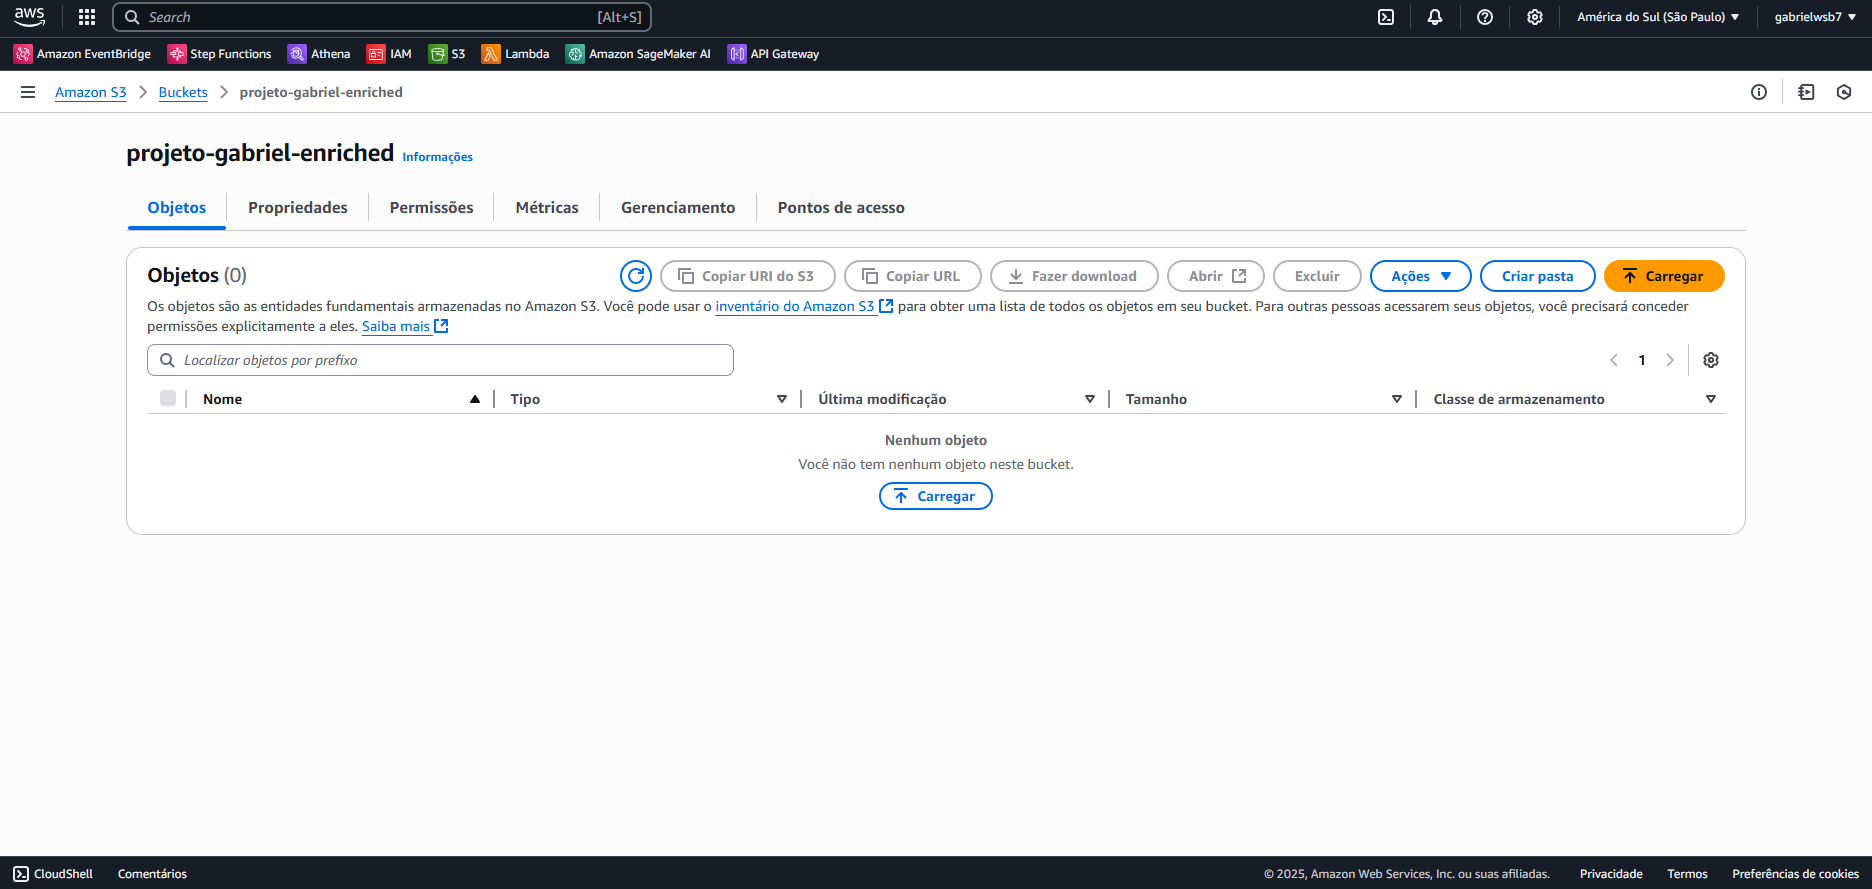

### 6.2 AWS Lambda

Na etapa de ETL, o AWS Lambda tem a função de ativamente processar as mensagens captadas pelo bot do Telegram, persistidas na camada cru (raw) no bucket do AWS S3, e persisti-las na camada enriquecida, também em um bucket do AWS S3. Logo, vamos criar uma função que opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

Nesta etapa iremos repetir o que foi feito no item 5.2:
* Criar as variáveis de ambiente
* Adicionar as permissões
* Criar a função
* Configurar um recurso
* Adicionar o pacote do PyArrow no ambiente do AWS Lambda

* Variáveis de ambiente criadas

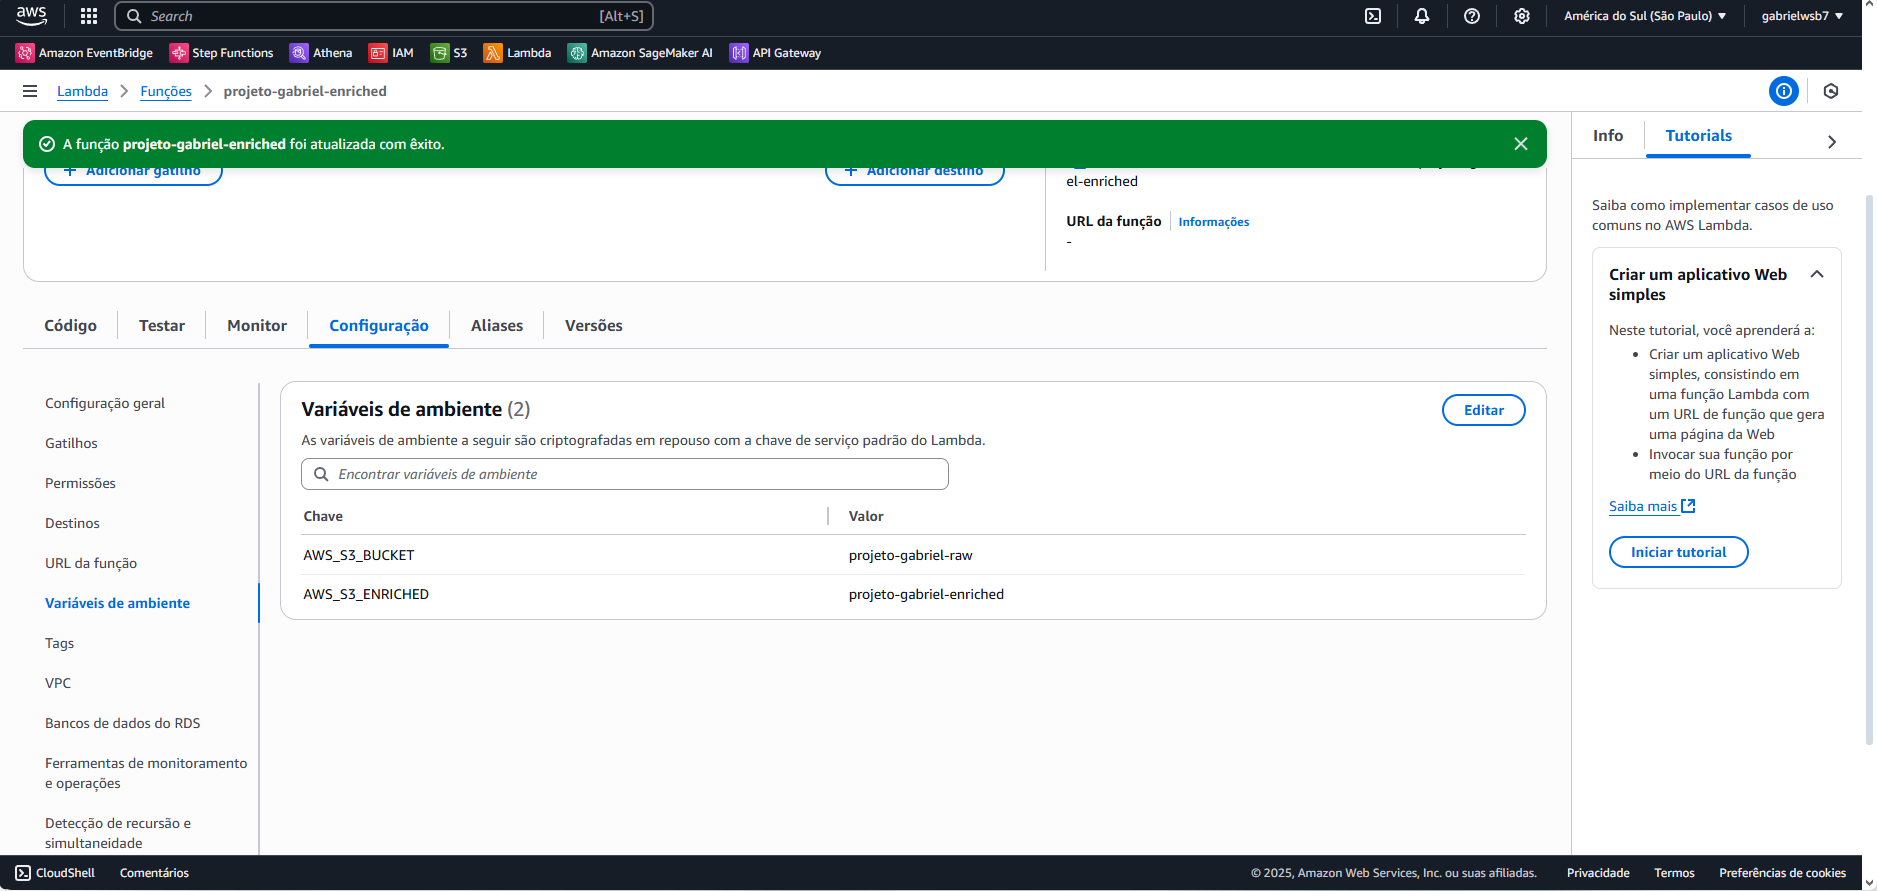

* Código da função

In [ ]:
def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # Variáveis de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # Variáveis lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # Código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

* Código responsável pelo data wrangling

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

* Função criada

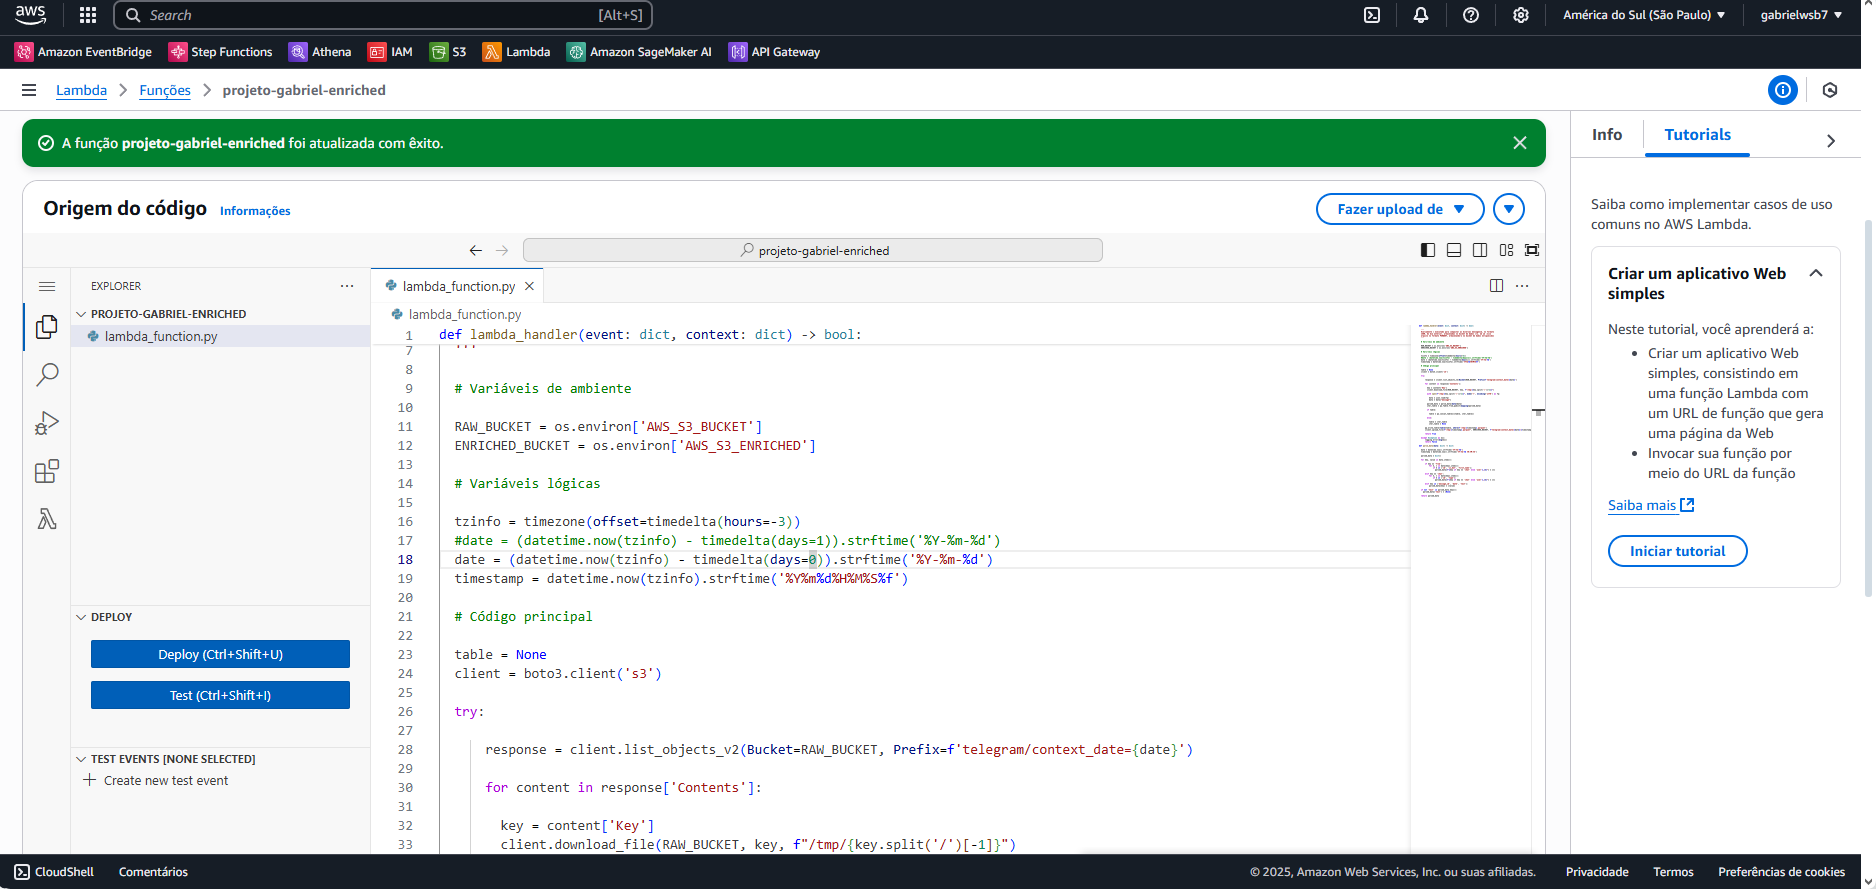

* Permissões concedidas

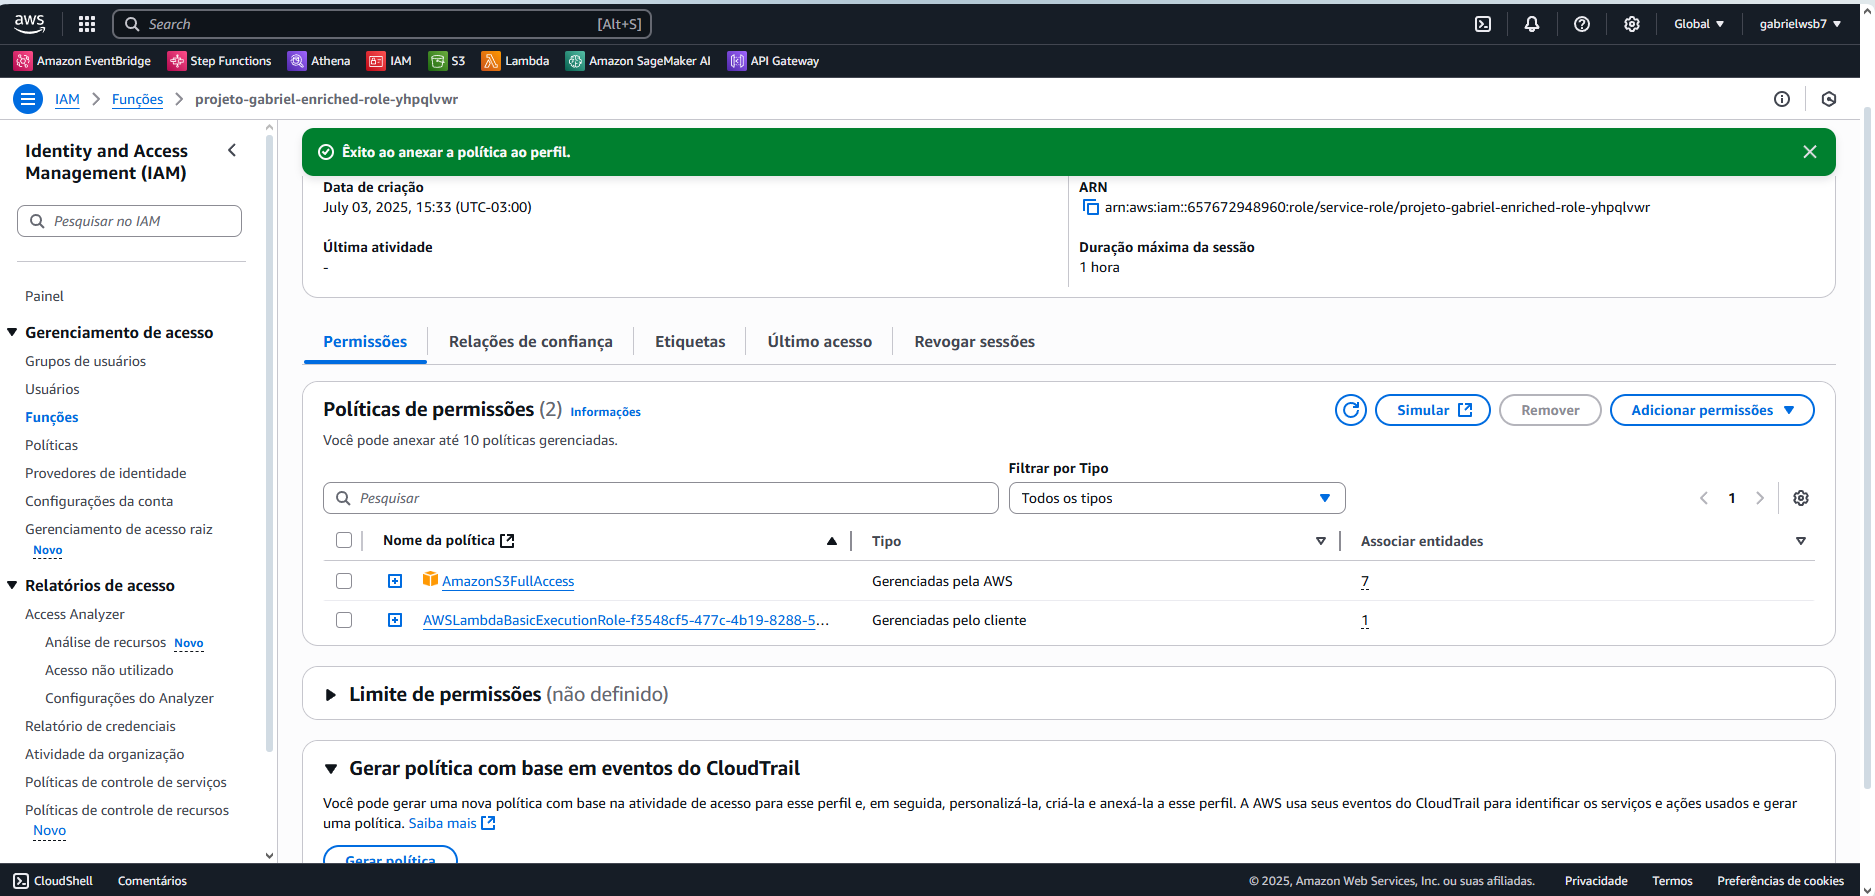

* Ajustando o recurso do tempo para execução correta do código

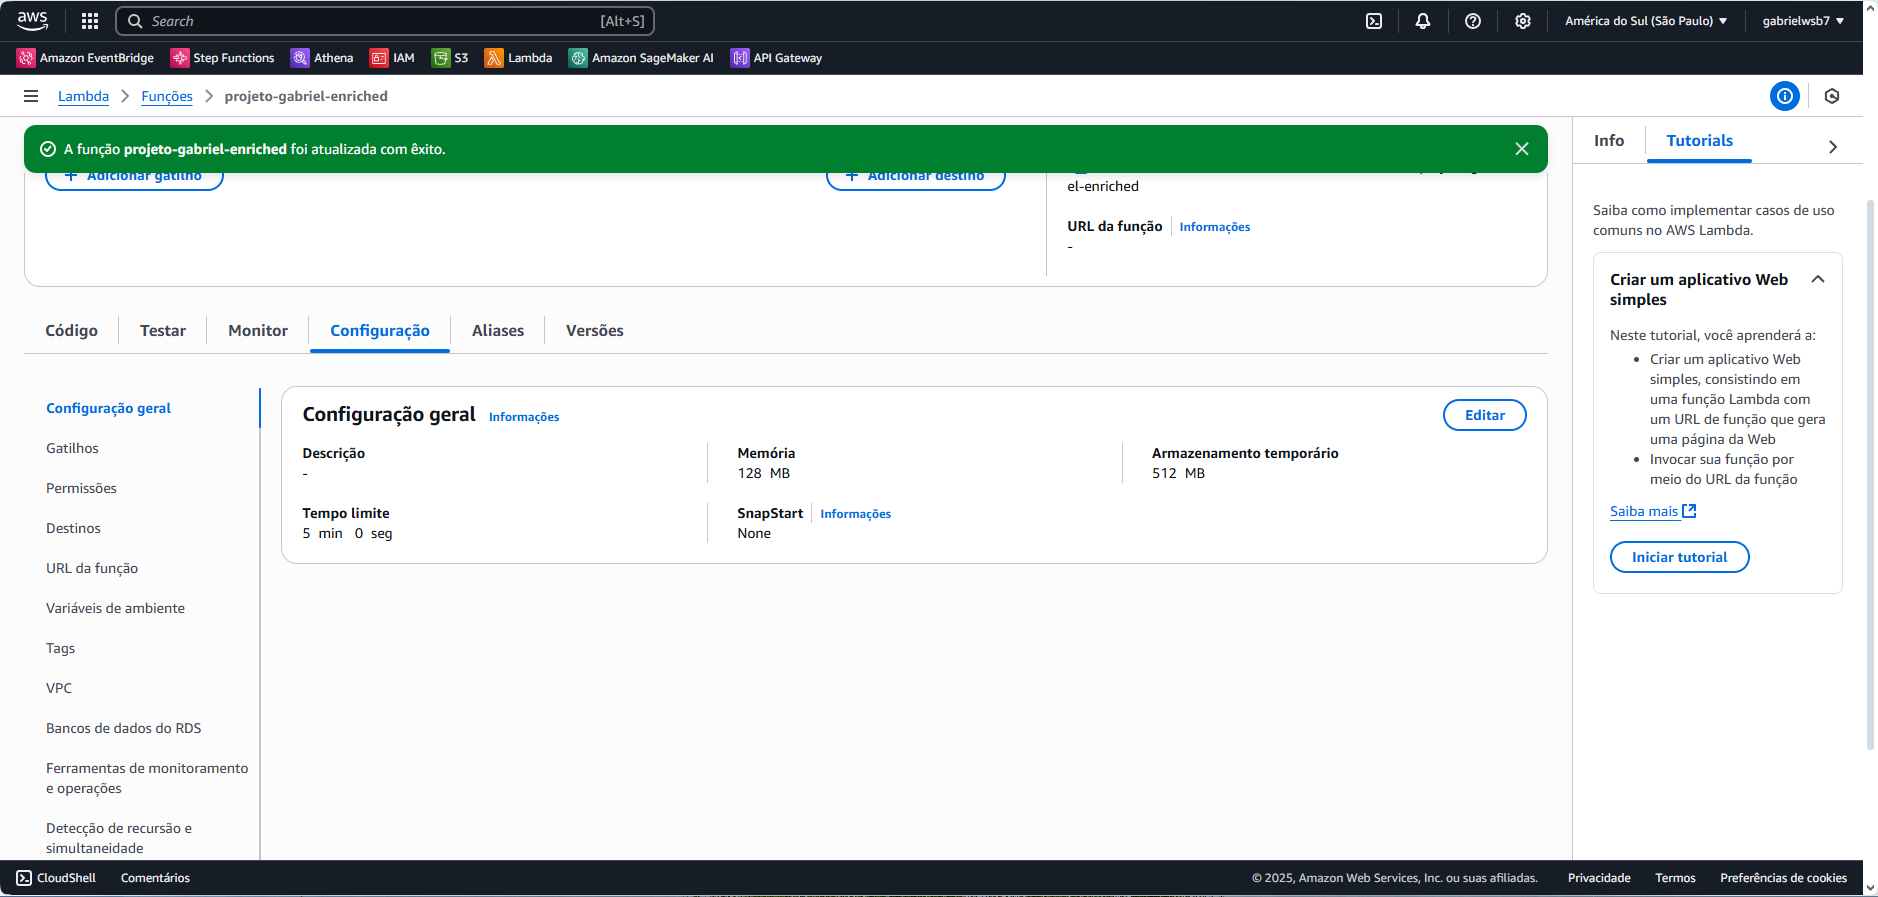

* Adicionar o pacote Pyarrow

Para fazer esse procedimento vou adicionar através de uma camada no AWS Lambda

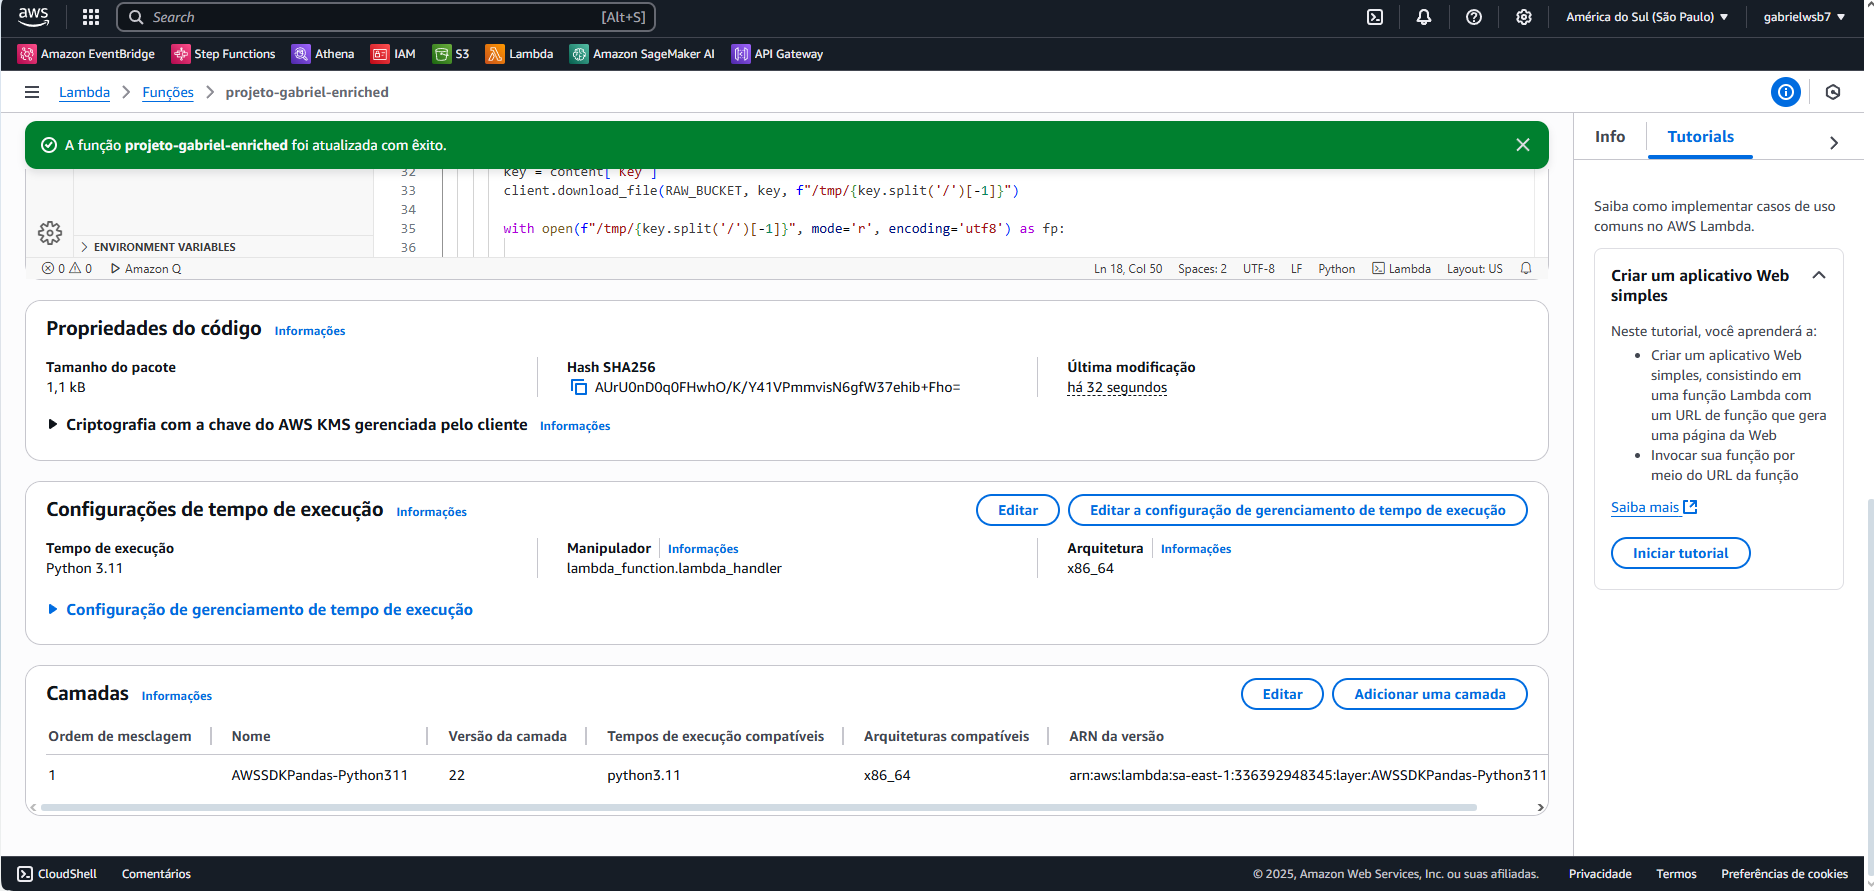

Configuração finalizada, agora vamos testar a função

* Teste realizado com sucesso

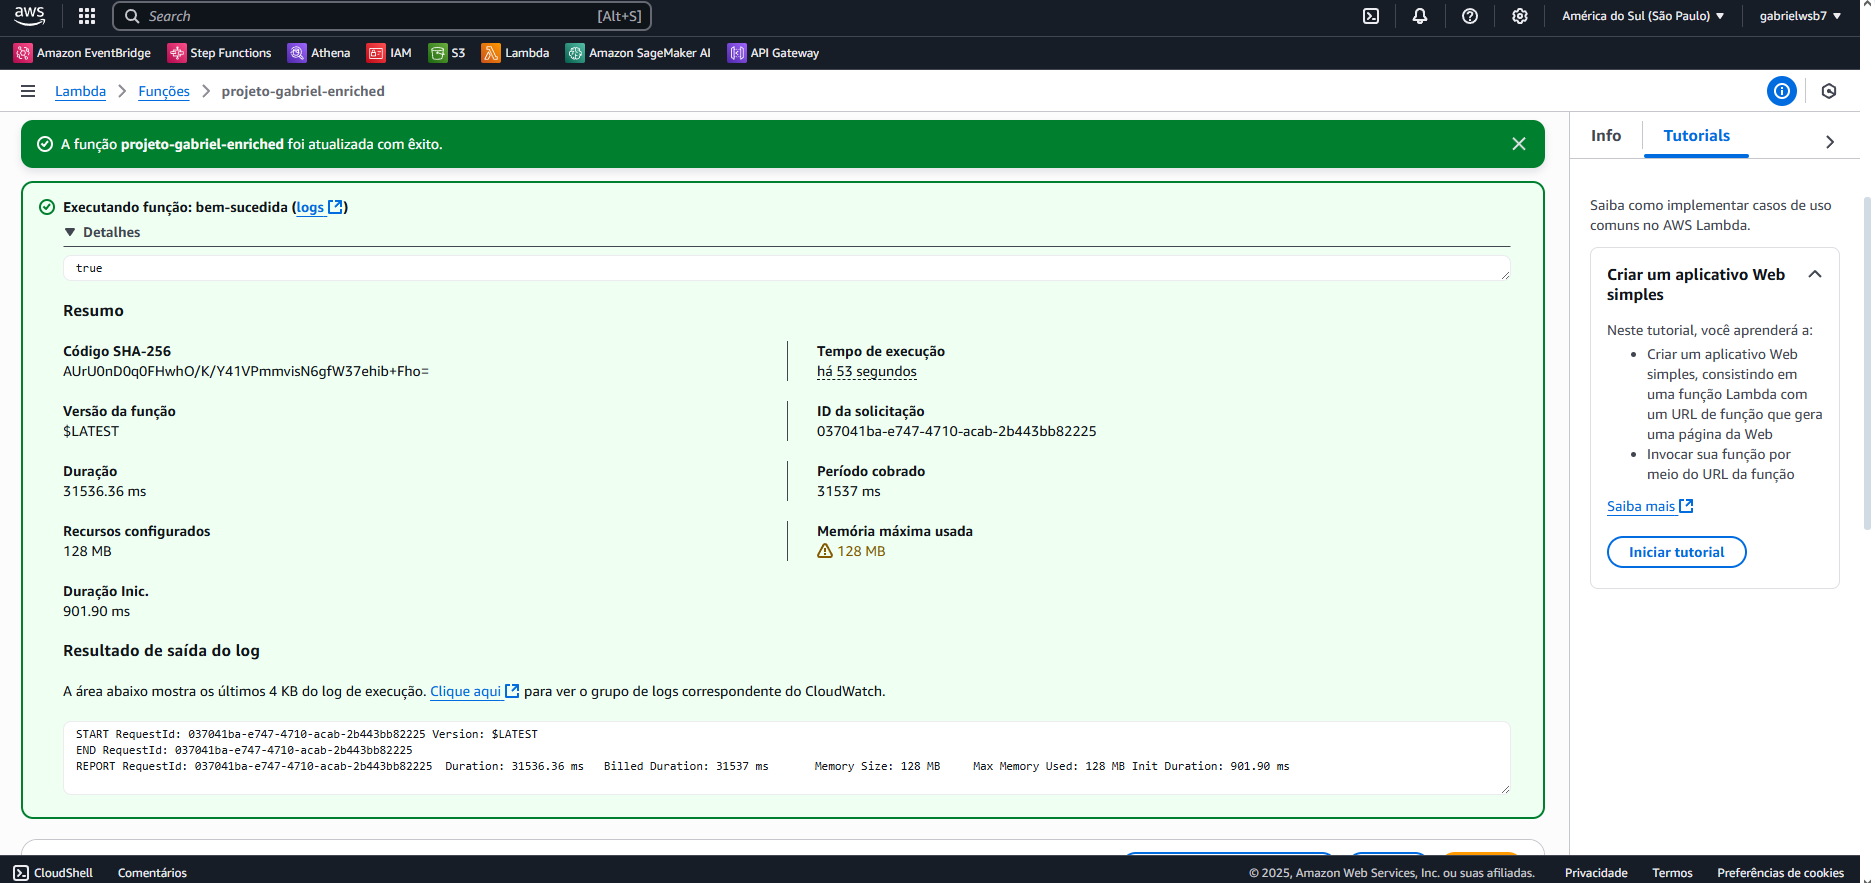

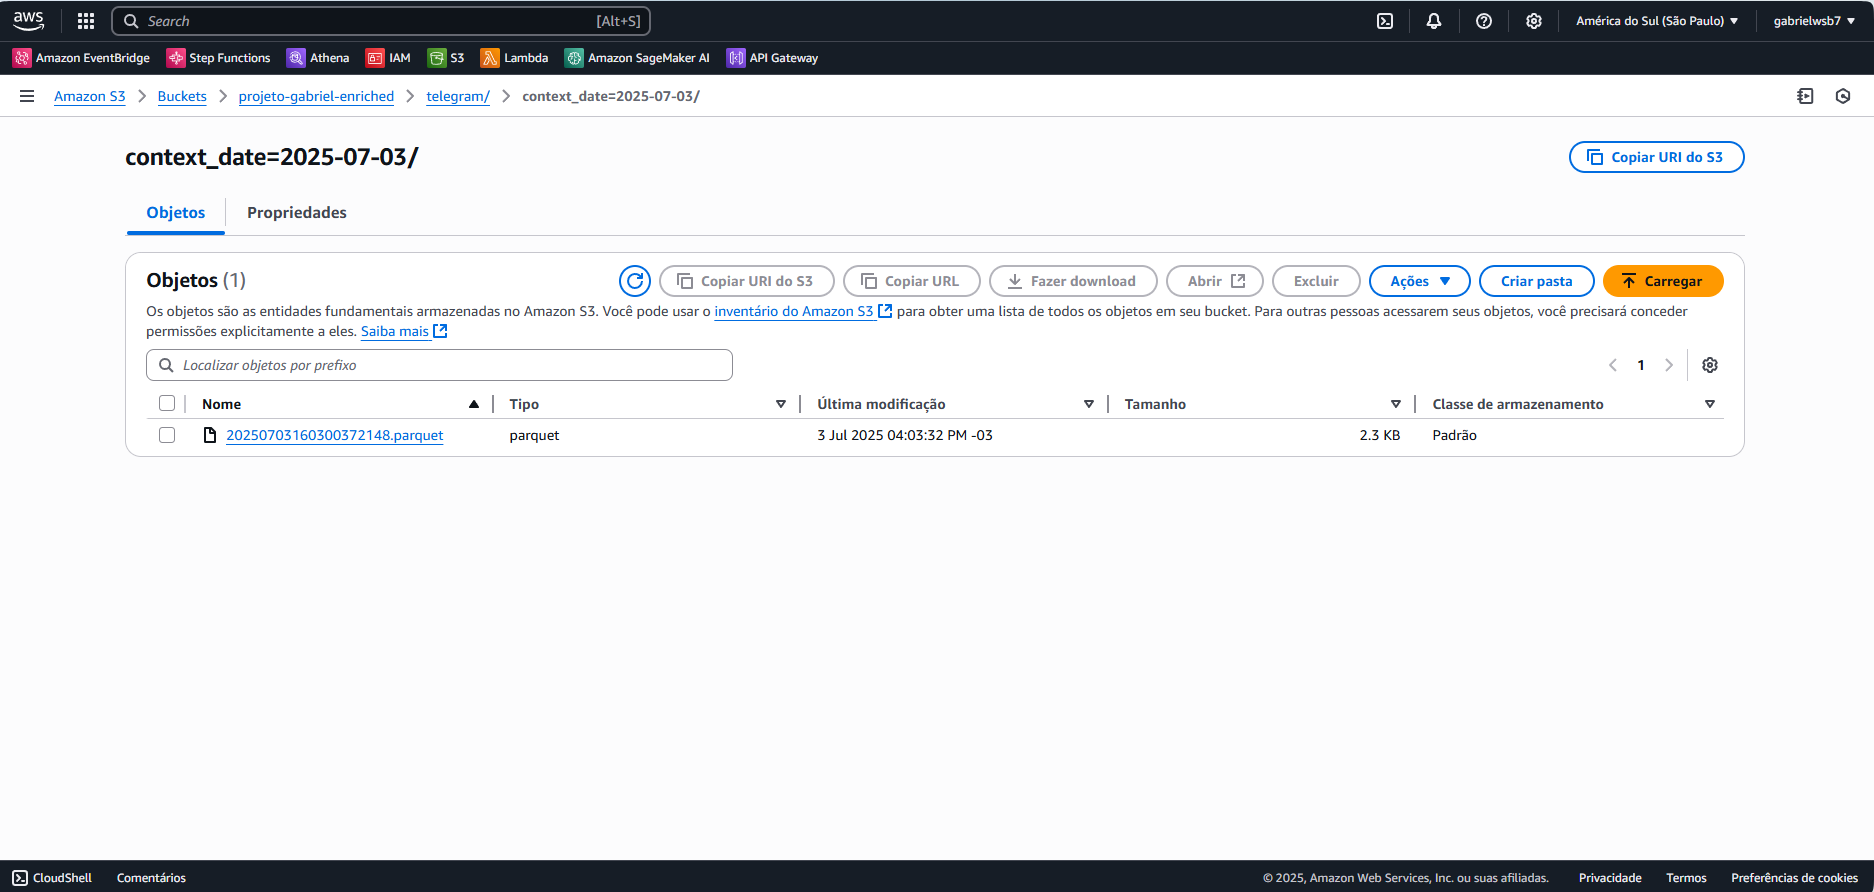

### 6.3 AWS Event Bridge

Na etapa de ETL, o AWS Event Bridge tem a função de ativar diariamente a função de ETL do AWS Lambda, funcionando assim como um *scheduler*.

* Regra criada

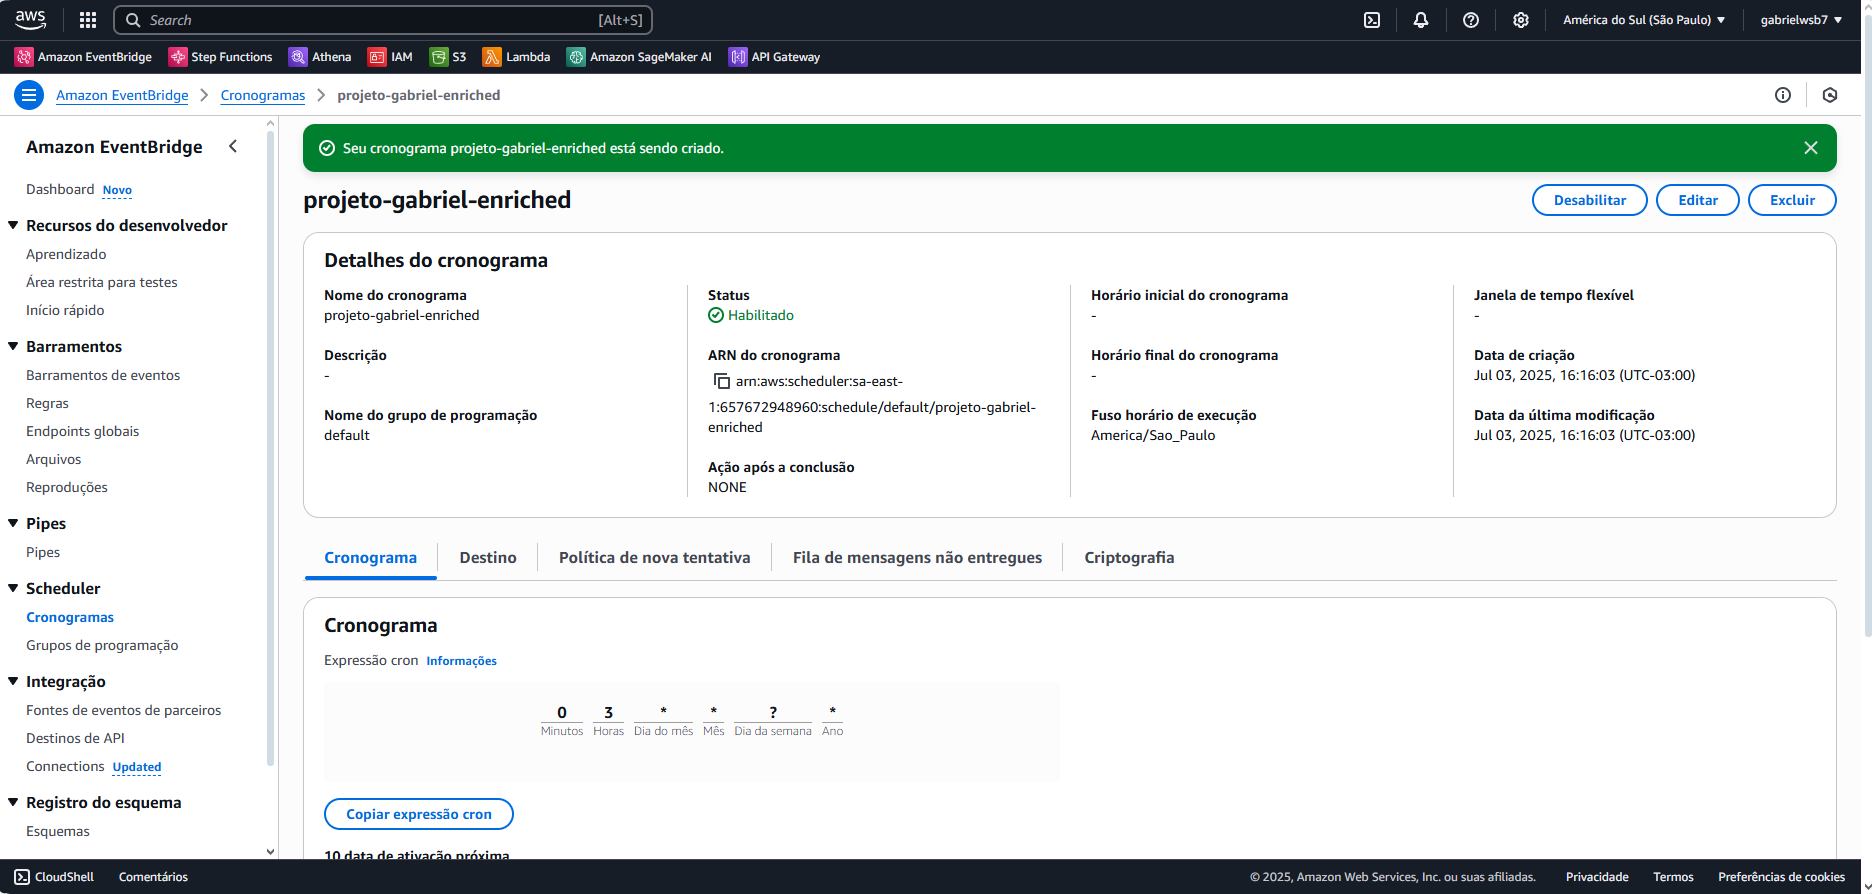

Desta forma, o projeto está devidamente configurado. Agora vou testar alguns códigos em SQL para averiguar a praticidade do projeto.

## 7. SQL no AWS Athena

Nesta etapa final, eu pensei nas análises que serão feitas em SQL. Logo o formato do arquivo é o .parquet (arquivo muito leve para consultas) e os dados ja estão particionados, o que reduzirá os custos de consultas.

* Para criar a tabela, utilizo o seguinte código:

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://projeto-gabriel-enriched/telegram'

```

* Adicionar as partições

```sql
MSCK REPAIR TABLE `telegram`;
```

* Query 1: Primeira consulta

```sql
SELECT * FROM "default"."telegram" limit 10;
```

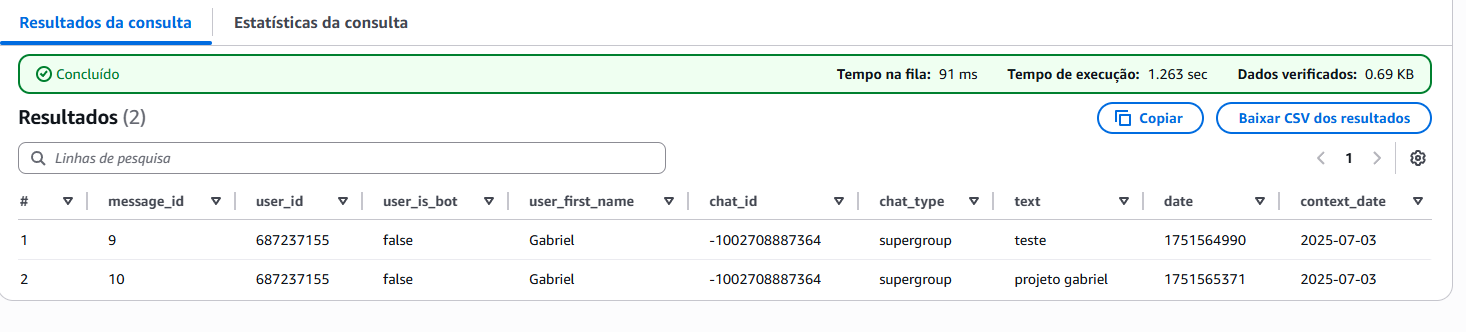

Descrição das colunas do arquivo:

| chave | tipo valor | descrição |
| -- | -- | -- |
| message_id | int | id da mensagem enviada ao grupo |
| user_id | int | id do usuário que enviou a mensagem |
| user_is_bot | bool |se o usuário que enviou a mensagem é um bot |
| user_first_name | str | primeiro nome do usário que enviou a mensagem |
| chat_id | int | id do chat em que a mensagem foi enviada |
| chat_type | str | tipo do chat: private, group, supergroup ou channel |
| text | str | texto da mensagem |
| date | int | data de envio da mensagem no formato unix|
| context-date | date | data da mensagem formato padrão|


Agora vou executar algumas querys para mostrar as possibilidades do projeto

* Query 2: quantidade de mensagens por dia

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

* Query 3: quantidade de mensagens por usuário

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

* Query 4: quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

Onde:
* parsed_date_hour: horário cheio que a mensagem foi enviada
* parsed_date_weekday: dia da semana, onde 0 é domingo e 7 é sábado
* parsed_date_weeknum: número da semana, desde o inicio do ano
* message_amount: quantidade de mensagens

## 8. Considerações Finais

Esse projeto foi uma forma prática de mostrar como podemos usar a tecnologia para transformar dados simples — como mensagens enviadas em um grupo do Telegram — em algo útil para gerar insights e apoiar decisões.

A ideia foi construir uma estrutura automática que pega essas mensagens, processa e organiza tudo de forma eficiente, usando serviços da AWS como o Lambda, S3 e API Gateway. Tudo isso sem depender de servidores, com baixo custo e bastante escalável.

O que mais gostei nesse projeto foi perceber como pequenas ações (como salvar uma mensagem no formato certo ou organizar os dados por dia) fazem diferença na hora de analisar. Dá pra imaginar facilmente uma empresa usando algo parecido para entender melhor seus clientes, melhorar o atendimento ou até treinar melhor seu chatbot.

No fim das contas, mais do que um exercício técnico, esse projeto mostra como dados do dia a dia — se bem tratados — podem virar informação valiosa.